# Multi-Model Assertion Dataset Comparison

This notebook compares how different language models respond to various types of assertions across different categories and dimensions. It provides comprehensive analysis of model behavior patterns, strengths, and weaknesses.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from glob import glob
import warnings
warnings.filterwarnings('ignore')
import os
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

os.chdir('..')
print(os.getcwd())

# Set up plotting style
import matplotlib
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

# Color palette for models
MODEL_COLORS = {
    'meta_llama_Llama_3_1_8B_Instruct': '#1f77b4',
    'meta_llama_Llama_3_1_8B': '#ff7f0e',
    # Add more colors as needed for additional models
    'model3': '#2ca02c',
    'model4': '#d62728',
    'model5': '#9467bd'
}

print("Setup complete!")

model_label_map = {
    "meta_llama_Llama_3_1_8B_Instruct_generated_assertions_v2_500": "LLaMA3-8B-Instruct",
    "meta_llama_Llama_3_1_8B_generated_assertions_v2_500": "LLaMA3-8B",
    "meta_llama_Llama_3_2_1B_Instruct_generated_assertions_v2_500": "LLaMA3-1B-Instruct",
    "meta_llama_Llama_3_2_1B_generated_assertions_v2_500": "LLaMA3-1B",
    "meta_llama_Llama_3_2_3B_Instruct_generated_assertions_v2_500": "LLaMA3-3B-Instruct",
    "meta_llama_Llama_3_2_3B_generated_assertions_v2_500": "LLaMA3-3B",
}


/Users/kdu/code/rycolab/Assertions
Setup complete!


## Data Loading and Preprocessing

In [2]:
def load_model_data(data_dir='data', min_examples=1000):
    """
    Load results from all available models in the data directory.
    Returns a dictionary with model names as keys and DataFrames as values.
    """
    model_data = {}
    data_path = Path(data_dir)
    
    # Find all model directories
    model_dirs = [d for d in data_path.iterdir() if d.is_dir() and not d.name.startswith('.')]
    
    for model_dir in model_dirs:
        results_file = model_dir / 'results.csv'
        if results_file.exists():
            model_name = model_dir.name
            print(f"Loading data for {model_name}...")
            
            try:
                df = pd.read_csv(results_file)
               
                if len(df) < min_examples:
                    print(f"Skipping {model_name} (only {len(df)} examples, below threshold of {min_examples})")
                    continue  # skip datasets below threshold
            
                df['model'] = model_name
                df['fact_id'] = df['subject'] + ' -> ' + df['object_true']
                df['confidence'] = abs(df['yes_probability'] - df['no_probability'])
                
                
                model_data[model_name] = df
                print(f"  - Loaded {len(df)} examples")
            except Exception as e:
                print(f"  - Error loading {model_name}: {e}")
        else:
            print(f"No results.csv found for {model_dir.name}")
    
    return model_data

# Load all model data
model_data = load_model_data()
print(f"\nLoaded data for {len(model_data)} models: {list(model_data.keys())}")

# Combine all data into a single DataFrame for easier analysis
if model_data:
    combined_df = pd.concat(model_data.values(), ignore_index=True)
    print(f"Combined dataset shape: {combined_df.shape}")
else:
    print("No model data found!")

Loading data for meta_llama_Llama_3_1_8B_generated_assertions_v2_500...
  - Loaded 17000 examples
Loading data for meta_llama_Llama_3_1_8B...
Skipping meta_llama_Llama_3_1_8B (only 416 examples, below threshold of 1000)
Loading data for meta_llama_Llama_3_2_3B_Instruct_generated_assertions_v2_500...
  - Loaded 17000 examples
Loading data for meta_llama_Llama_3_2_1B_Instruct_generated_assertions_v2_500...
  - Loaded 17000 examples
Loading data for meta_llama_Llama_3_2_1B_generated_assertions_v2_500...
  - Loaded 17000 examples
Loading data for meta_llama_Llama_3_1_8B_Instruct...
Skipping meta_llama_Llama_3_1_8B_Instruct (only 418 examples, below threshold of 1000)
No results.csv found for __pycache__
Loading data for meta_llama_Llama_3_2_3B_generated_assertions_v2_500...
  - Loaded 17000 examples
Loading data for meta_llama_Llama_3_1_8B_Instruct_generated_assertions_v2_500...
  - Loaded 17000 examples

Loaded data for 6 models: ['meta_llama_Llama_3_1_8B_generated_assertions_v2_500', 'me

In [3]:
model_data.keys()

dict_keys(['meta_llama_Llama_3_1_8B_generated_assertions_v2_500', 'meta_llama_Llama_3_2_3B_Instruct_generated_assertions_v2_500', 'meta_llama_Llama_3_2_1B_Instruct_generated_assertions_v2_500', 'meta_llama_Llama_3_2_1B_generated_assertions_v2_500', 'meta_llama_Llama_3_2_3B_generated_assertions_v2_500', 'meta_llama_Llama_3_1_8B_Instruct_generated_assertions_v2_500'])

In [4]:
combined_df.columns

Index(['example_id', 'assertion', 'query', 'prompt', 'generated_answer',
       'yes_probability', 'no_probability', 'classification', 'dimension',
       'category', 'subject', 'object', 'object_true', 'model', 'fact_id',
       'confidence'],
      dtype='object')

In [5]:
# Basic overview of the dataset
if len(model_data) > 0:
    print("=== DATASET OVERVIEW ===")
    print(f"Total models: {len(model_data)}")
    print(f"Available columns: {list(combined_df.columns)}")
    
    print("\n=== MODEL STATISTICS ===")
    for model_name, df in model_data.items():
        print(f"\n{model_name}:")
        print(f"  Examples: {len(df)}")
        print(f"  Classifications: {dict(df['classification'].value_counts())}")
        print(f"  Categories: {len(df['category'].unique())} unique")
        print(f"  Dimensions: {len(df['dimension'].unique())} unique")
        print(f"  Facts: {len(df['fact_id'].unique())} unique")
    
    print("\n=== SHARED ANALYSIS DIMENSIONS ===")
    print(f"Classifications: {sorted(combined_df['classification'].unique())}")
    print(f"Categories: {sorted(combined_df['category'].unique())}")
    print(f"Dimensions: {sorted(combined_df['dimension'].unique())}")
    print(f"Unique facts: {len(combined_df['fact_id'].unique())}")
else:
    print("No model data available for analysis.")

=== DATASET OVERVIEW ===
Total models: 6
Available columns: ['example_id', 'assertion', 'query', 'prompt', 'generated_answer', 'yes_probability', 'no_probability', 'classification', 'dimension', 'category', 'subject', 'object', 'object_true', 'model', 'fact_id', 'confidence']

=== MODEL STATISTICS ===

meta_llama_Llama_3_1_8B_generated_assertions_v2_500:
  Examples: 17000
  Classifications: {'context': np.int64(14347), 'memory': np.int64(2358), 'other': np.int64(295)}
  Categories: 17 unique
  Dimensions: 4 unique
  Facts: 3140 unique

meta_llama_Llama_3_2_3B_Instruct_generated_assertions_v2_500:
  Examples: 17000
  Classifications: {'context': np.int64(15762), 'memory': np.int64(1001), 'other': np.int64(237)}
  Categories: 17 unique
  Dimensions: 4 unique
  Facts: 3140 unique

meta_llama_Llama_3_2_1B_Instruct_generated_assertions_v2_500:
  Examples: 17000
  Classifications: {'context': np.int64(15123), 'memory': np.int64(1617), 'other': np.int64(260)}
  Categories: 17 unique
  Dimensi

In [6]:
# Detailed analysis by category
category_summary = []
for (category, dimension, model), cat_data in combined_df.groupby(['category', 'dimension', 'model']):#.unique():
    # cat_data = df[df['category'] == category]
    total = len(cat_data)
    
    summary = {
        'category': category,
        'dimension': dimension,
        'total_examples': total,
        'model': model_label_map[model],
        'memory_pct': (len(cat_data[cat_data['classification'] == 'memory']) / total) * 100,
        'context_pct': (len(cat_data[cat_data['classification'] == 'context']) / total) * 100,
        'other_pct': (len(cat_data[cat_data['classification'] == 'other']) / total) * 100,
        'avg_yes_prob': cat_data['yes_probability'].mean(),
        'avg_no_prob': cat_data['no_probability'].mean(),
        'avg_confidence': cat_data['confidence'].mean(),
        'std_yes_prob': cat_data['yes_probability'].std(),
        'std_no_prob': cat_data['no_probability'].std()
    }
    category_summary.append(summary)

category_summary_df = pd.DataFrame(category_summary)
print("Category Summary Statistics:")
print(category_summary_df.round(3))

Category Summary Statistics:
      category         dimension  total_examples               model  \
0    authority     evidentiality            1000  LLaMA3-8B-Instruct   
1    authority     evidentiality            1000           LLaMA3-8B   
2    authority     evidentiality            1000  LLaMA3-1B-Instruct   
3    authority     evidentiality            1000           LLaMA3-1B   
4    authority     evidentiality            1000  LLaMA3-3B-Instruct   
..         ...               ...             ...                 ...   
97        weak  epistemic_stance            1000           LLaMA3-8B   
98        weak  epistemic_stance            1000  LLaMA3-1B-Instruct   
99        weak  epistemic_stance            1000           LLaMA3-1B   
100       weak  epistemic_stance            1000  LLaMA3-3B-Instruct   
101       weak  epistemic_stance            1000           LLaMA3-3B   

     memory_pct  context_pct  other_pct  avg_yes_prob  avg_no_prob  \
0          22.3         77.7        

In [7]:
sorted(category_summary_df["model"].unique())

['LLaMA3-1B',
 'LLaMA3-1B-Instruct',
 'LLaMA3-3B',
 'LLaMA3-3B-Instruct',
 'LLaMA3-8B',
 'LLaMA3-8B-Instruct']

            category         dimension  total_examples      model  memory_pct  \
3        conditional              form            1000  LLaMA3-1B        18.2   
7            hearsay     evidentiality            1000  LLaMA3-1B        18.2   
16              weak  epistemic_stance            1000  LLaMA3-1B        24.2   
13           sarcasm              tone            1000  LLaMA3-1B        27.8   
10     interrogative              form            1000  LLaMA3-1B        32.5   
9           informal              tone            1000  LLaMA3-1B        33.9   
1     belief_reports     evidentiality            1000  LLaMA3-1B        42.9   
0          authority     evidentiality            1000  LLaMA3-1B        38.3   
11      not_at_issue              form            1000  LLaMA3-1B        31.5   
6           explicit              form            1000  LLaMA3-1B        40.5   
15            strong  epistemic_stance            1000  LLaMA3-1B        46.5   
4     counterfactual        

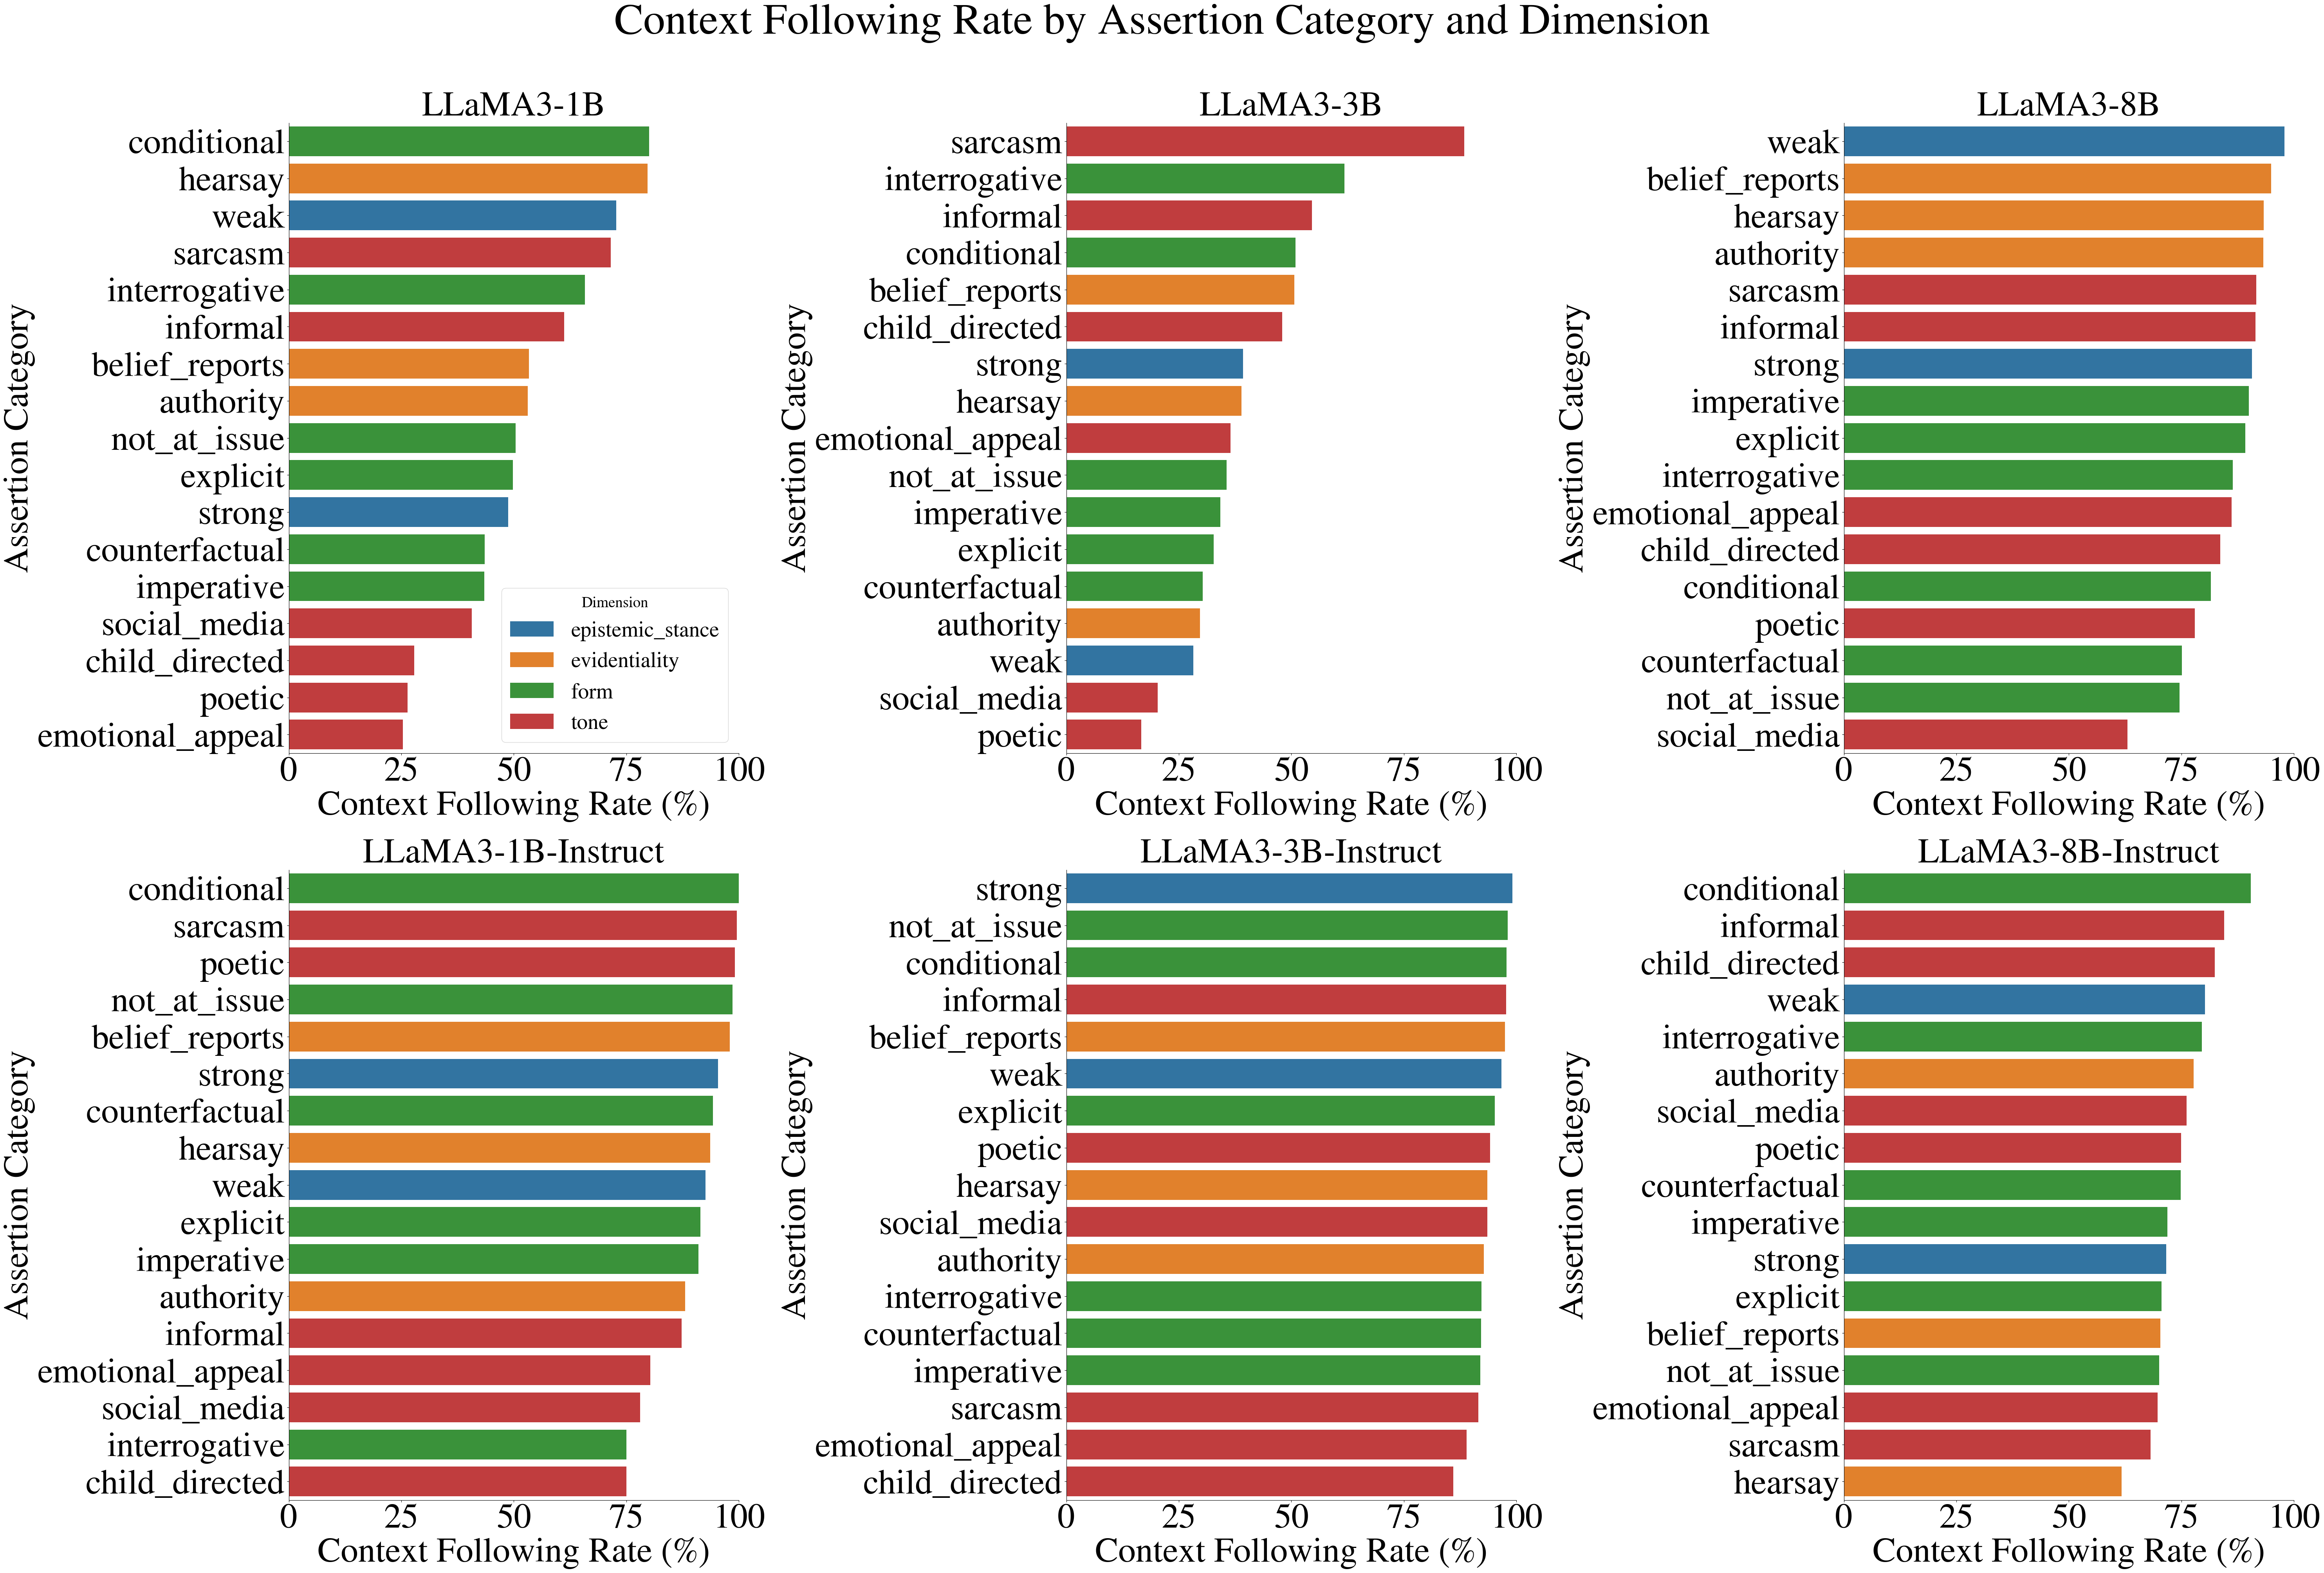

In [8]:
fig, axes = plt.subplots(figsize=(60, 40), ncols=3, nrows=2)
hue_order = sorted(category_summary_df["dimension"].unique())
for i, (model, ax) in enumerate(zip(sorted(category_summary_df["model"].unique(), key=lambda x: ("Instruct" in x)*100 + int(x.split("-")[1][0])), axes.flatten())):
    model_df = category_summary_df[category_summary_df["model"] == model].reset_index(drop=True)
    model_df['context_following_rate'] = (
        model_df['context_pct'] / 
        (model_df['context_pct'] + model_df['memory_pct'])
    ) * 100


    # Sort by context following rate
    model_df_sorted = model_df.sort_values('context_following_rate', ascending=False)
    category_order = model_df_sorted.index.tolist()
    print(model_df_sorted)

    sns.barplot(data=model_df_sorted, y="category", x='context_following_rate', hue="dimension", hue_order=hue_order, legend="auto" if i == 0 else False, ax=ax)
    ax.set_xlim(0, 100)
    fig.suptitle("Context Following Rate by Assertion Category and Dimension", fontsize=80, y=1.01)
    ax.set_title(model, fontsize=64)
    ax.set_xlabel("Context Following Rate (%)", fontsize=64)
    ax.set_ylabel("Assertion Category", fontsize=64)
    if i == 0:
        ax.legend(title="Dimension", fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=64)
plt.tight_layout()
plt.savefig(f"plots/context_following_rate_by_category_and_dimension_{model}.png")


### Context Following Rate (per model)

In [9]:
def context_following_rate(df):
    return (df['classification'] == 'context').mean()

model_stats = pd.DataFrame([
    {
        'model': name,
        'context_rate': context_following_rate(df),
        'memory_rate': (df['classification'] == 'memory').mean(),
        'other_rate': (df['classification'] == 'other').mean()
    }
    for name, df in model_data.items()
]).sort_values('context_rate', ascending=False)

display(model_stats)

,model,context_rate,memory_rate,other_rate
1,meta_llama_Llama_3_2_3B_Instruct_generated_ass...,0.927176,0.058882,0.013941
2,meta_llama_Llama_3_2_1B_Instruct_generated_ass...,0.889588,0.095118,0.015294
0,meta_llama_Llama_3_1_8B_generated_assertions_v...,0.843941,0.138706,0.017353
5,meta_llama_Llama_3_1_8B_Instruct_generated_ass...,0.748412,0.249824,0.001765
3,meta_llama_Llama_3_2_1B_generated_assertions_v...,0.463059,0.412765,0.124176
4,meta_llama_Llama_3_2_3B_generated_assertions_v...,0.402882,0.579059,0.018059


### Assertion Effectiveness (across all models)
How persuasive is each category (e.g., belief reports, counterfactuals) on average?

In [10]:
category_stats = (
    combined_df.groupby('category')['classification']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .sort_values('context', ascending=False)
)

display(category_stats)

classification,context,memory,other
category,,,
sarcasm,0.848167,0.147833,0.004000
conditional,0.822167,0.162500,0.015333
informal,0.777000,0.195667,0.027333
weak,0.763333,0.212000,0.024667
interrogative,0.752833,0.227167,0.020000
belief_reports,0.752667,0.216667,0.030667
hearsay,0.748167,0.226500,0.025333
strong,0.727000,0.249167,0.023833
authority,0.705333,0.260167,0.034500


### Model × Category Matrix
Which models are more or less persuaded by certain assertion categories?

In [11]:
model_category_matrix = (
    combined_df.groupby(['model', 'category'])['classification']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .reset_index()
    .pivot(index='model', columns='category', values='context')
    .fillna(0)
)

display(model_category_matrix)

category,authority,belief_reports,child_directed,conditional,counterfactual,emotional_appeal,explicit,hearsay,imperative,informal,interrogative,not_at_issue,poetic,sarcasm,social_media,strong,weak
model,,,,,,,,,,,,,,,,,
meta_llama_Llama_3_1_8B_Instruct_generated_assertions_v2_500,0.777,0.703,0.824,0.904,0.748,0.696,0.706,0.616,0.719,0.845,0.795,0.681,0.749,0.681,0.761,0.716,0.802
meta_llama_Llama_3_1_8B_generated_assertions_v2_500,0.924,0.878,0.829,0.812,0.750,0.861,0.870,0.920,0.900,0.901,0.856,0.690,0.776,0.916,0.629,0.872,0.963
meta_llama_Llama_3_2_1B_Instruct_generated_assertions_v2_500,0.878,0.976,0.738,1.000,0.942,0.803,0.914,0.933,0.910,0.869,0.745,0.780,0.991,0.995,0.772,0.952,0.925
meta_llama_Llama_3_2_1B_generated_assertions_v2_500,0.433,0.491,0.265,0.730,0.412,0.220,0.401,0.716,0.409,0.535,0.624,0.320,0.224,0.698,0.306,0.442,0.646
meta_llama_Llama_3_2_3B_Instruct_generated_assertions_v2_500,0.926,0.974,0.823,0.978,0.921,0.885,0.952,0.922,0.920,0.976,0.891,0.845,0.941,0.915,0.935,0.991,0.967
meta_llama_Llama_3_2_3B_generated_assertions_v2_500,0.294,0.494,0.480,0.509,0.302,0.363,0.326,0.382,0.339,0.536,0.606,0.302,0.166,0.884,0.200,0.389,0.277


### Instruct vs Base Comparison
Compare context-following rates between base and instruct models of same size.

In [12]:
def model_family(name):
    if "1B" in name:
        return "1B"
    elif "2_3B" in name:
        return "2.3B"
    elif "8B" in name:
        return "8B"
    return "unknown"

def model_type(name):
    return "Instruct" if "Instruct" in name else "Base"

comparison_df = model_stats.copy()
comparison_df['size'] = comparison_df['model'].apply(model_family)
comparison_df['type'] = comparison_df['model'].apply(model_type)

# Group by size, compare context-following rate
summary = (
    comparison_df.pivot(index='size', columns='type', values='context_rate')
    .assign(delta=lambda x: x['Instruct'] - x['Base'])
)

display(summary)

type,Base,Instruct,delta
size,,,
1B,0.463059,0.889588,0.426529
2.3B,0.402882,0.927176,0.524294
8B,0.843941,0.748412,-0.095529


## Overall Model Performance Comparison

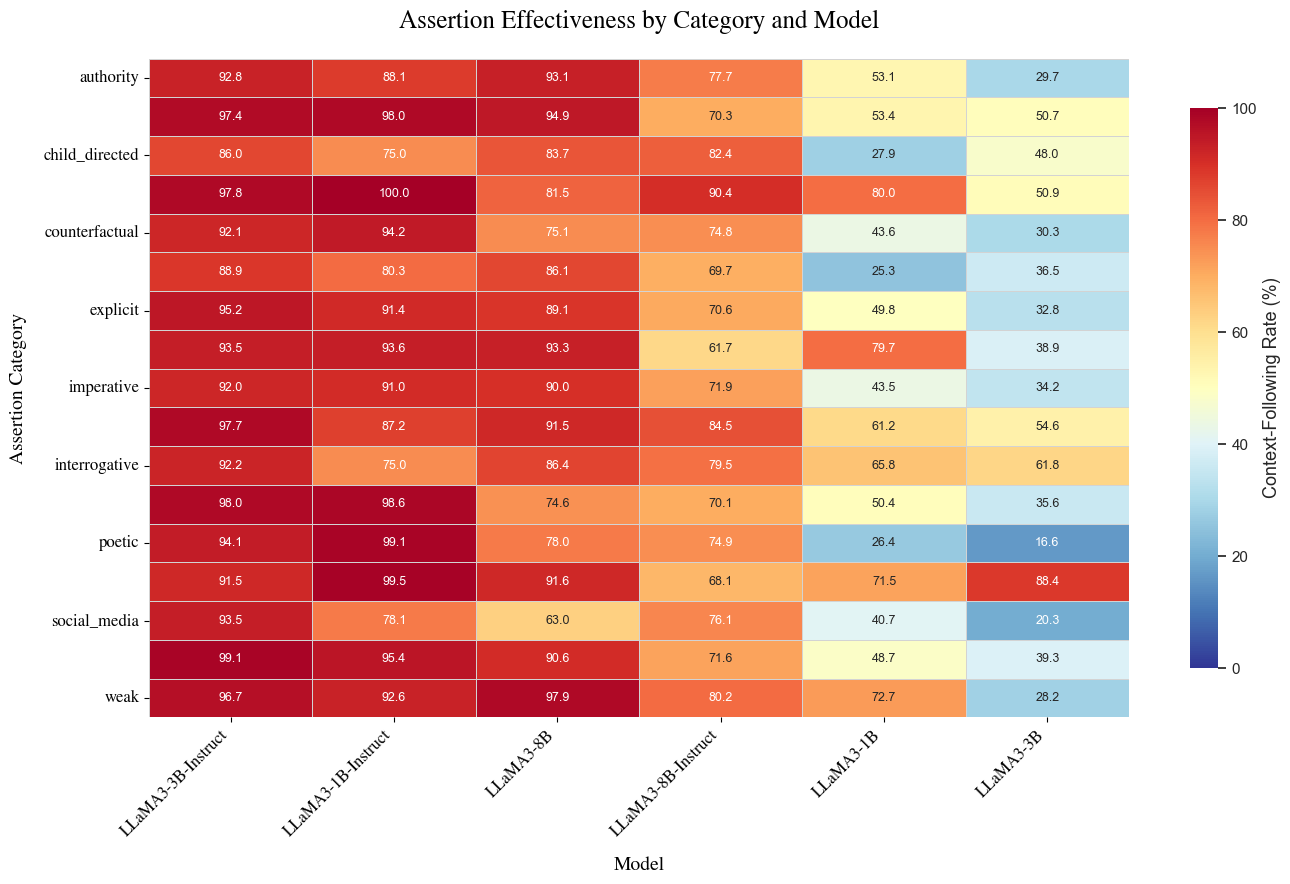

In [13]:
# Step 1: Calculate context-following rate per category per model
category_effectiveness = (
    combined_df[combined_df['classification'].isin(['context', 'memory'])]
    .groupby(['model', 'category', 'classification'])
    .size()
    .unstack(fill_value=0)
)

# Step 2: Compute context-following rate
category_effectiveness['context_rate'] = (
    category_effectiveness['context'] /
    (category_effectiveness['context'] + category_effectiveness['memory']) * 100
)

# Step 3: Pivot for heatmap: rows = categories, columns = models
effectiveness_matrix = category_effectiveness['context_rate'].unstack().T

# Step 4: Rename columns using short model labels
effectiveness_matrix.columns = [model_label_map.get(col, col) for col in effectiveness_matrix.columns]

# Optional: Sort rows (categories) by average context rate
effectiveness_matrix = effectiveness_matrix.loc[:, effectiveness_matrix.mean().sort_values(ascending=False).index]

# Step 5: Plot heatmap
fig, ax = plt.subplots(figsize=(14, 9))
sns.set(style="whitegrid")

heat = sns.heatmap(
    effectiveness_matrix,
    annot=True,
    fmt=".1f",
    cmap="RdYlBu_r",
    cbar_kws={'label': 'Context-Following Rate (%)', 'shrink': 0.85},
    linewidths=0.4,
    linecolor='lightgray',
    vmin=0,
    vmax=100,
    annot_kws={"size": 9},
    ax=ax
)

# Titles and labels
ax.set_title("Assertion Effectiveness by Category and Model", fontsize=18, pad=22)
ax.set_xlabel("Model", fontsize=14, labelpad=12)
ax.set_ylabel("Assertion Category", fontsize=14, labelpad=12)

# Tick styling
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)

# Colorbar styling
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=11)
cbar.set_label('Context-Following Rate (%)', size=13)

plt.tight_layout()
plt.show()

## Category-Level Analysis

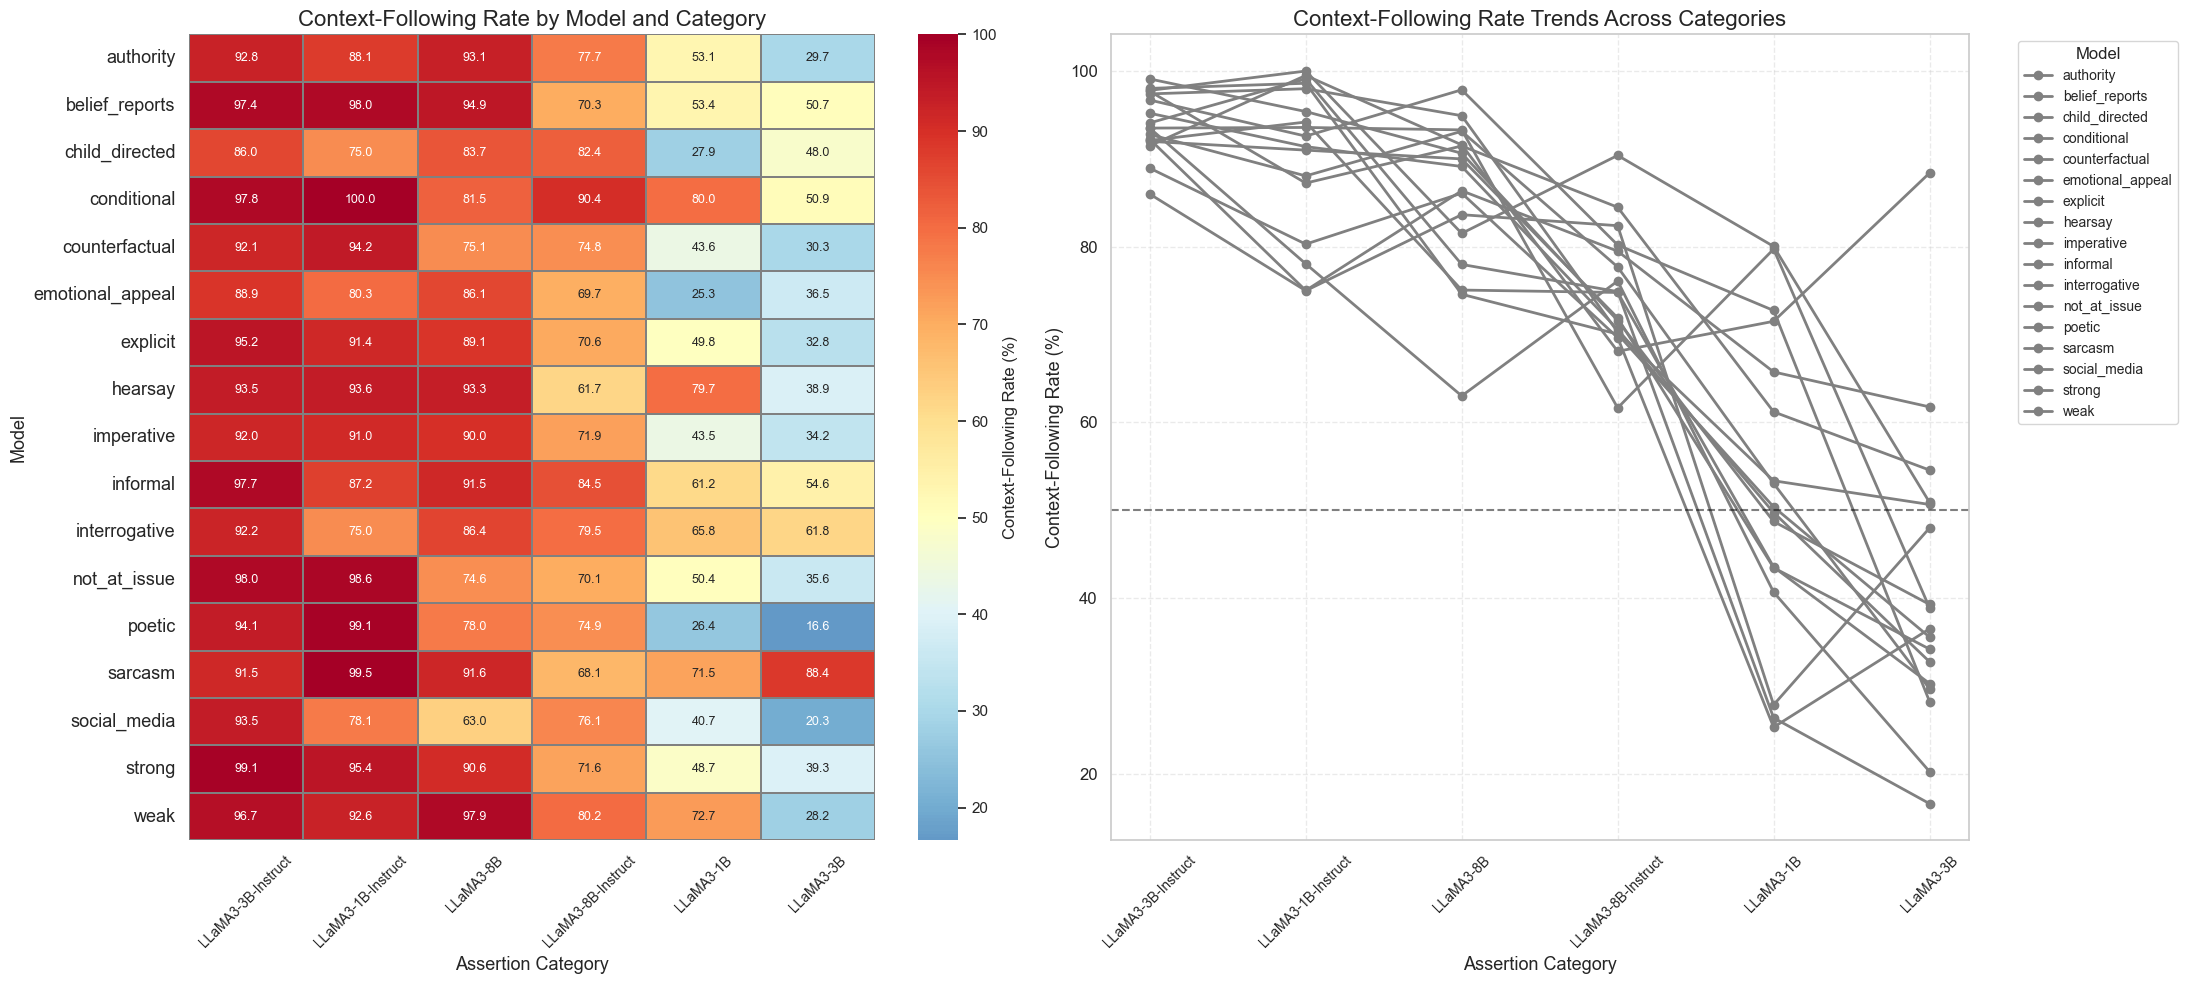

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

# 1. Heatmapblob:vscode-webview://0ksb5tau7d6n9tnd2kpc197v0m9m56h1mhtmni8nmfsmmge15pmp/b1185a31-ce77-4735-b8ae-93c904877366
sns.heatmap(
    effectiveness_matrix,
    annot=True,
    fmt='.1f',
    cmap='RdYlBu_r',
    center=50,
    ax=ax1,
    cbar_kws={'label': 'Context-Following Rate (%)'},
    linewidths=0.3,
    linecolor='gray',
    annot_kws={'size': 9}
)
ax1.set_title('Context-Following Rate by Model and Category', fontsize=16)
ax1.set_xlabel('Assertion Category', fontsize=13)
ax1.set_ylabel('Model', fontsize=13)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.tick_params(axis='y', labelsize=13)

# 2. Line Plot
for model in effectiveness_matrix.index:
    color = MODEL_COLORS.get(model, 'gray')
    ax2.plot(
        effectiveness_matrix.columns, effectiveness_matrix.loc[model],
        label=model, marker='o', linewidth=2, color=color
    )

ax2.axhline(50, color='black', linestyle='--', alpha=0.5)
ax2.set_title('Context-Following Rate Trends Across Categories', fontsize=16)
ax2.set_xlabel('Assertion Category', fontsize=13)
ax2.set_ylabel('Context-Following Rate (%)', fontsize=13)
ax2.tick_params(axis='x', rotation=45, labelsize=10)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.legend(
    title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12
)

plt.tight_layout()
plt.show()

## Dimension-Level Analysis

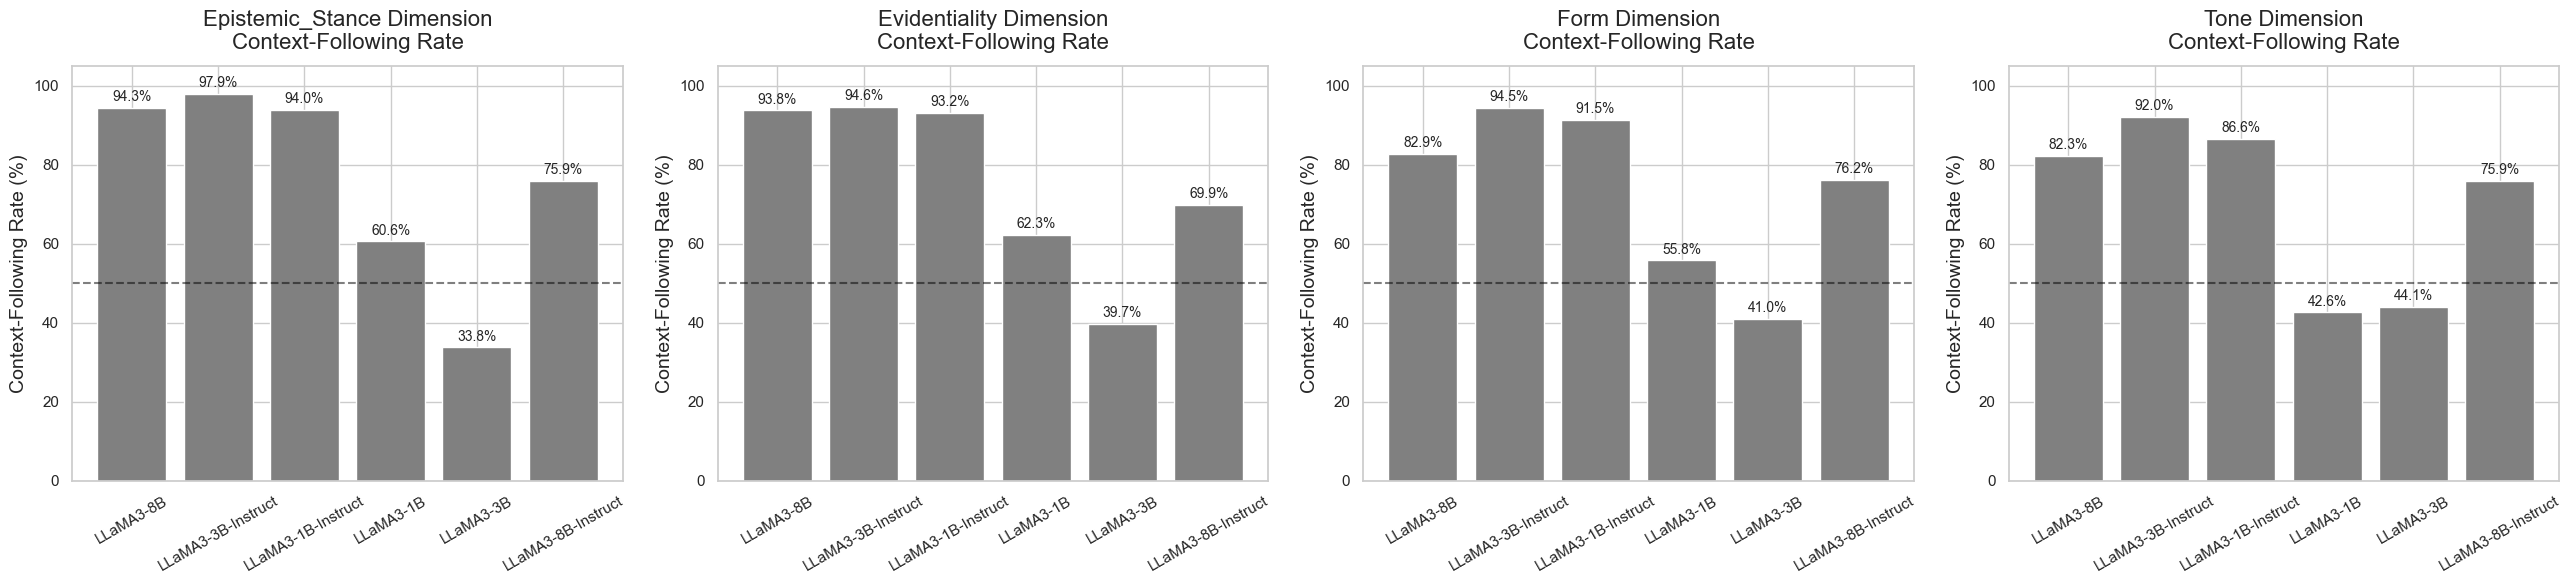


=== DIMENSION EFFECTIVENESS COMPARISON ===


,LLaMA3-8B,LLaMA3-3B-Instruct,LLaMA3-1B-Instruct,LLaMA3-1B,LLaMA3-3B,LLaMA3-8B-Instruct
dimension,,,,,,
epistemic_stance,94.3,97.9,94.0,60.6,33.8,75.9
evidentiality,93.8,94.6,93.2,62.3,39.7,69.9
form,82.9,94.5,91.5,55.8,41.0,76.2
tone,82.3,92.0,86.6,42.6,44.1,75.9


In [15]:
# --- Dimension Effectiveness Plot ---

if len(model_data) > 1:
    dimensions = sorted(combined_df['dimension'].unique())

    # Compute context-following rate per dimension per model
    dimension_effectiveness = []
    for dimension in dimensions:
        row = {"dimension": dimension}
        for model_name, df in model_data.items():
            dim_df = df[df['dimension'] == dimension]
            mem = len(dim_df[dim_df['classification'] == 'memory'])
            ctx = len(dim_df[dim_df['classification'] == 'context'])
            total = mem + ctx
            row[model_name] = (ctx / total * 100) if total > 0 else np.nan
        dimension_effectiveness.append(row)

    dimension_df = pd.DataFrame(dimension_effectiveness).set_index("dimension")

    # Plotting setup
    fig, axes = plt.subplots(1, len(dimensions), figsize=(6.5 * len(dimensions), 6))
    if len(dimensions) == 1:
        axes = [axes]

    for i, dim in enumerate(dimensions):
        ax = axes[i]
        values = dimension_df.loc[dim]
        short_labels = [model_label_map.get(m, m) for m in values.index]
        bar_colors = [MODEL_COLORS.get(model_label_map.get(m, m), '#808080') for m in values.index]

        bars = ax.bar(short_labels, values.values, color=bar_colors)

        # Titles and styling
        ax.set_title(f'{dim.title()} Dimension\nContext-Following Rate', fontsize=16, pad=12)
        ax.set_ylabel('Context-Following Rate (%)', fontsize=14)
        ax.axhline(y=50, color='black', linestyle='--', alpha=0.5)
        ax.set_ylim(0, 105)
        ax.tick_params(axis='x', rotation=30, labelsize=11)
        ax.tick_params(axis='y', labelsize=11)

        for bar, val in zip(bars, values.values):
            if not np.isnan(val):
                ax.text(bar.get_x() + bar.get_width() / 2, val + 1,
                        f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print Table
    print("\n=== DIMENSION EFFECTIVENESS COMPARISON ===")
    display(dimension_df.rename(columns=model_label_map).round(1))

else:
    print("Need at least 2 models for comparison.")

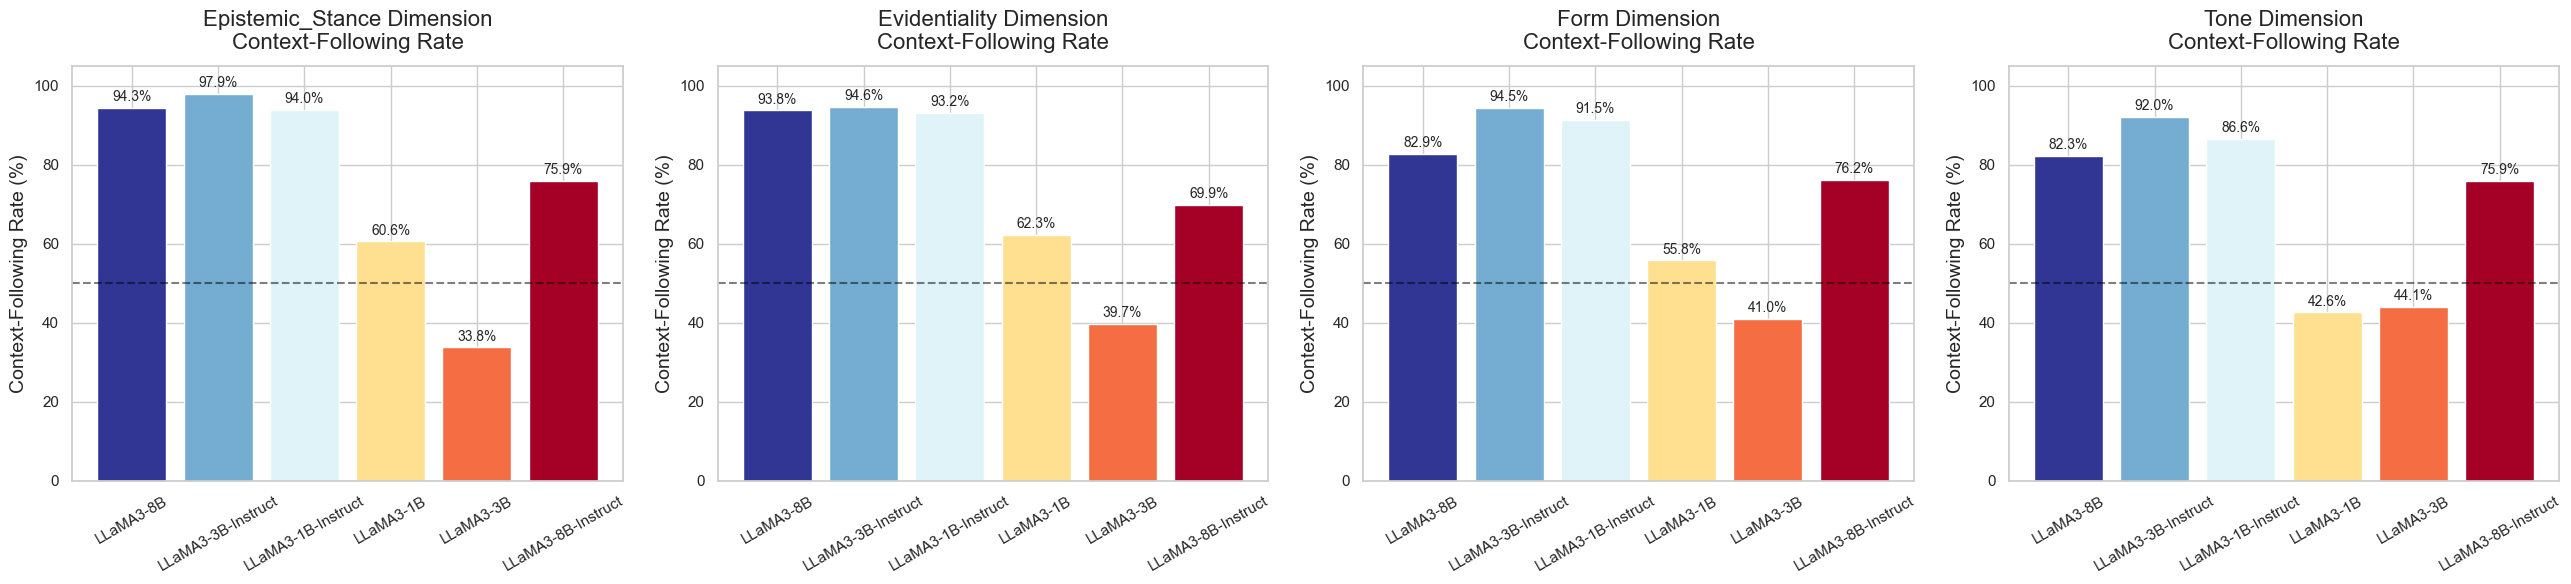


=== DIMENSION EFFECTIVENESS COMPARISON ===


,LLaMA3-8B,LLaMA3-3B-Instruct,LLaMA3-1B-Instruct,LLaMA3-1B,LLaMA3-3B,LLaMA3-8B-Instruct
dimension,,,,,,
epistemic_stance,94.3,97.9,94.0,60.6,33.8,75.9
evidentiality,93.8,94.6,93.2,62.3,39.7,69.9
form,82.9,94.5,91.5,55.8,41.0,76.2
tone,82.3,92.0,86.6,42.6,44.1,75.9


In [16]:
# --- Dimension Effectiveness Plot ---

if len(model_data) > 1:
    dimensions = sorted(combined_df['dimension'].unique())

    # Compute context-following rate per dimension per model
    dimension_effectiveness = []
    for dimension in dimensions:
        row = {"dimension": dimension}
        for model_name, df in model_data.items():
            dim_df = df[df['dimension'] == dimension]
            mem = len(dim_df[dim_df['classification'] == 'memory'])
            ctx = len(dim_df[dim_df['classification'] == 'context'])
            total = mem + ctx
            row[model_name] = (ctx / total * 100) if total > 0 else np.nan
        dimension_effectiveness.append(row)

    dimension_df = pd.DataFrame(dimension_effectiveness).set_index("dimension")

    # Plotting setup
    fig, axes = plt.subplots(1, len(dimensions), figsize=(6.5 * len(dimensions), 6))
    if len(dimensions) == 1:
        axes = [axes]

    for i, dim in enumerate(dimensions):
        ax = axes[i]
        values = dimension_df.loc[dim]
        short_labels = [model_label_map.get(m, m) for m in values.index]
        
        short_labels = [model_label_map.get(m, m) for m in values.index]
        
       
        cmap = get_cmap("RdYlBu_r")
        norm = Normalize(vmin=0, vmax=len(values) - 1)
        bar_colors = [cmap(norm(i)) for i in range(len(values))]

        bars = ax.bar(short_labels, values.values, color=bar_colors)

        # Titles and styling
        ax.set_title(f'{dim.title()} Dimension\nContext-Following Rate', fontsize=16, pad=12)
        ax.set_ylabel('Context-Following Rate (%)', fontsize=14)
        ax.axhline(y=50, color='black', linestyle='--', alpha=0.5)
        ax.set_ylim(0, 105)
        ax.tick_params(axis='x', rotation=30, labelsize=11)
        ax.tick_params(axis='y', labelsize=11)

        for bar, val in zip(bars, values.values):
            if not np.isnan(val):
                ax.text(bar.get_x() + bar.get_width() / 2, val + 1,
                        f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print Table
    print("\n=== DIMENSION EFFECTIVENESS COMPARISON ===")
    display(dimension_df.rename(columns=model_label_map).round(1))

else:
    print("Need at least 2 models for comparison.")

## Fact-Level Consistency Analysis

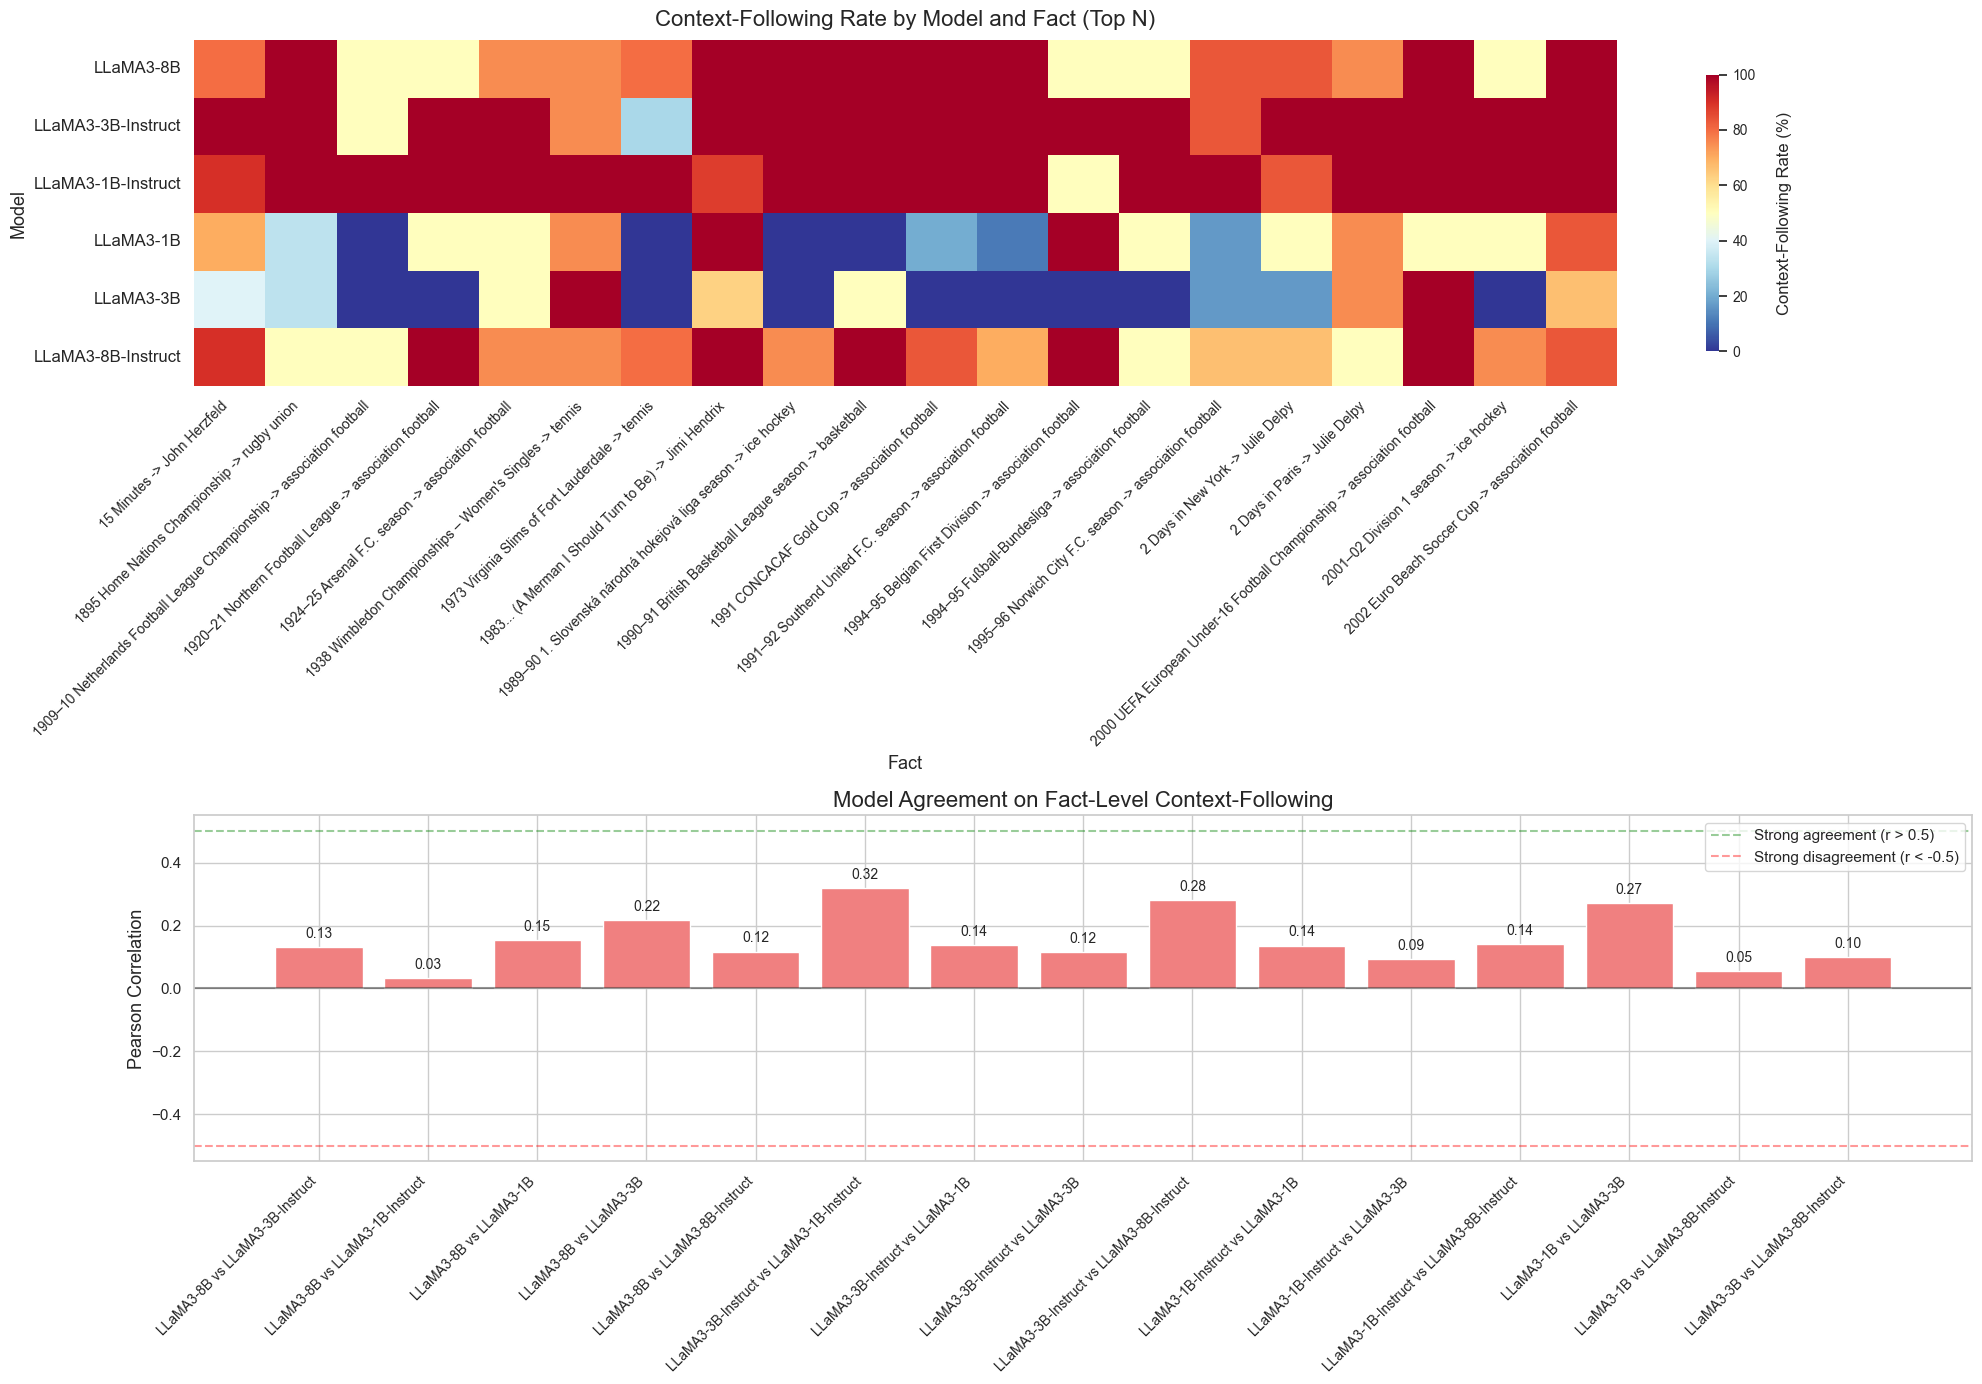


=== FACT-LEVEL CONSISTENCY ===


,LLaMA3-8B,LLaMA3-3B-Instruct,LLaMA3-1B-Instruct,LLaMA3-1B,LLaMA3-3B,LLaMA3-8B-Instruct
fact_id,,,,,,
15 Minutes -> John Herzfeld,80.0,100.0,90.0,70.0,40.0,90.0
1895 Home Nations Championship -> rugby union,100.0,100.0,100.0,33.3,33.3,50.0
1909–10 Netherlands Football League Championship -> association football,50.0,50.0,100.0,0.0,0.0,50.0
1920–21 Northern Football League -> association football,50.0,100.0,100.0,50.0,0.0,100.0
1924–25 Arsenal F.C. season -> association football,75.0,100.0,100.0,50.0,50.0,75.0
...,...,...,...,...,...,...
Đurđa Ivezić -> actor,100.0,66.7,83.3,0.0,50.0,50.0
Łukasz Szukała -> association football,62.5,100.0,100.0,42.9,75.0,62.5
Şefik Birkiye -> architect,100.0,90.0,100.0,77.8,80.0,80.0



=== MODEL AGREEMENT (Pearson correlations) ===
LLaMA3-8B vs LLaMA3-3B-Instruct: r = 0.131 on 3135 facts
LLaMA3-8B vs LLaMA3-1B-Instruct: r = 0.032 on 3129 facts
LLaMA3-8B vs LLaMA3-1B: r = 0.153 on 3080 facts
LLaMA3-8B vs LLaMA3-3B: r = 0.216 on 3133 facts
LLaMA3-8B vs LLaMA3-8B-Instruct: r = 0.117 on 3138 facts
LLaMA3-3B-Instruct vs LLaMA3-1B-Instruct: r = 0.318 on 3129 facts
LLaMA3-3B-Instruct vs LLaMA3-1B: r = 0.137 on 3078 facts
LLaMA3-3B-Instruct vs LLaMA3-3B: r = 0.115 on 3131 facts
LLaMA3-3B-Instruct vs LLaMA3-8B-Instruct: r = 0.280 on 3136 facts
LLaMA3-1B-Instruct vs LLaMA3-1B: r = 0.136 on 3075 facts
LLaMA3-1B-Instruct vs LLaMA3-3B: r = 0.094 on 3127 facts
LLaMA3-1B-Instruct vs LLaMA3-8B-Instruct: r = 0.142 on 3130 facts
LLaMA3-1B vs LLaMA3-3B: r = 0.271 on 3076 facts
LLaMA3-1B vs LLaMA3-8B-Instruct: r = 0.055 on 3080 facts
LLaMA3-3B vs LLaMA3-8B-Instruct: r = 0.100 on 3133 facts


In [17]:
# --- FACT-LEVEL CONTEXT CONSISTENCY ---

if len(model_data) > 1:
    # Compute context-following rate per fact per model
    facts = sorted(combined_df['fact_id'].unique())
    model_names = list(model_data.keys())

    fact_consistency = []
    for fact in facts:
        row = {"fact_id": fact}
        for model_name in model_names:
            df = model_data[model_name]
            sub = df[df['fact_id'] == fact]
            mem = len(sub[sub['classification'] == 'memory'])
            ctx = len(sub[sub['classification'] == 'context'])
            total = mem + ctx
            row[model_name] = (ctx / total * 100) if total > 0 else np.nan
        fact_consistency.append(row)

    fact_df = pd.DataFrame(fact_consistency).set_index("fact_id")

    # Replace model names with short labels
    short_model_names = [model_label_map.get(m, m) for m in fact_df.columns]
    fact_df.columns = short_model_names

    # Reduce number of facts shown for readability
    TOP_N = 20
    fact_df_filtered = fact_df.dropna(axis=0, how='any').iloc[:TOP_N]

    # PLOTTING
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 14))

    # --- Heatmap ---
    heatmap = sns.heatmap(
        fact_df_filtered.T,
        annot=False,
        fmt=".1f",
        cmap='RdYlBu_r',
        center=50,
        ax=ax1,
        cbar_kws={'shrink': 0.8} 
    )

    # Adjust colorbar label manually
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_label('Context-Following Rate (%)', fontsize=12, labelpad=15)
    colorbar.ax.tick_params(labelsize=10)

    ax1.set_title("Context-Following Rate by Model and Fact (Top N)", fontsize=16, pad=10)
    ax1.set_xlabel("Fact", fontsize=13)
    ax1.set_ylabel("Model", fontsize=13)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)

    # --- Pairwise Correlation Plot ---
    correlations = []
    for i in range(len(short_model_names)):
        for j in range(i + 1, len(short_model_names)):
            m1, m2 = short_model_names[i], short_model_names[j]
            df_pair = fact_df[[m1, m2]].dropna()
            if len(df_pair) > 1:
                corr = df_pair[m1].corr(df_pair[m2])
                correlations.append({
                    "model1": m1,
                    "model2": m2,
                    "correlation": corr,
                    "n_common": len(df_pair)
                })

    if correlations:
        corr_df = pd.DataFrame(correlations)
        x = range(len(corr_df))
        labels = [f"{r['model1']} vs {r['model2']}" for r in correlations]
        bar_colors = ['steelblue' if r > 0.5 else 'lightcoral' for r in corr_df['correlation']]

        bars = ax2.bar(x, corr_df['correlation'], color=bar_colors)
        ax2.set_title("Model Agreement on Fact-Level Context-Following", fontsize=16)
        ax2.set_ylabel("Pearson Correlation", fontsize=13)
        ax2.set_xticks(x)
        ax2.set_xticklabels(labels, fontsize=10, rotation=45, ha='right')
        ax2.axhline(0, color='black', alpha=0.4)
        ax2.axhline(0.5, linestyle='--', color='green', alpha=0.4, label="Strong agreement (r > 0.5)")
        ax2.axhline(-0.5, linestyle='--', color='red', alpha=0.4, label="Strong disagreement (r < -0.5)")
        ax2.legend(fontsize=11)

        for bar, val in zip(bars, corr_df['correlation']):
            ax2.text(bar.get_x() + bar.get_width()/2, val + 0.02,
                     f"{val:.2f}", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # --- PRINT SUMMARY ---
    print("\n=== FACT-LEVEL CONSISTENCY ===")
    display(fact_df.round(1))

    if correlations:
        print("\n=== MODEL AGREEMENT (Pearson correlations) ===")
        for row in correlations:
            print(f"{row['model1']} vs {row['model2']}: r = {row['correlation']:.3f} on {row['n_common']} facts")

else:
    print("Need at least 2 models for comparison.")

## Probability Distribution Analysis

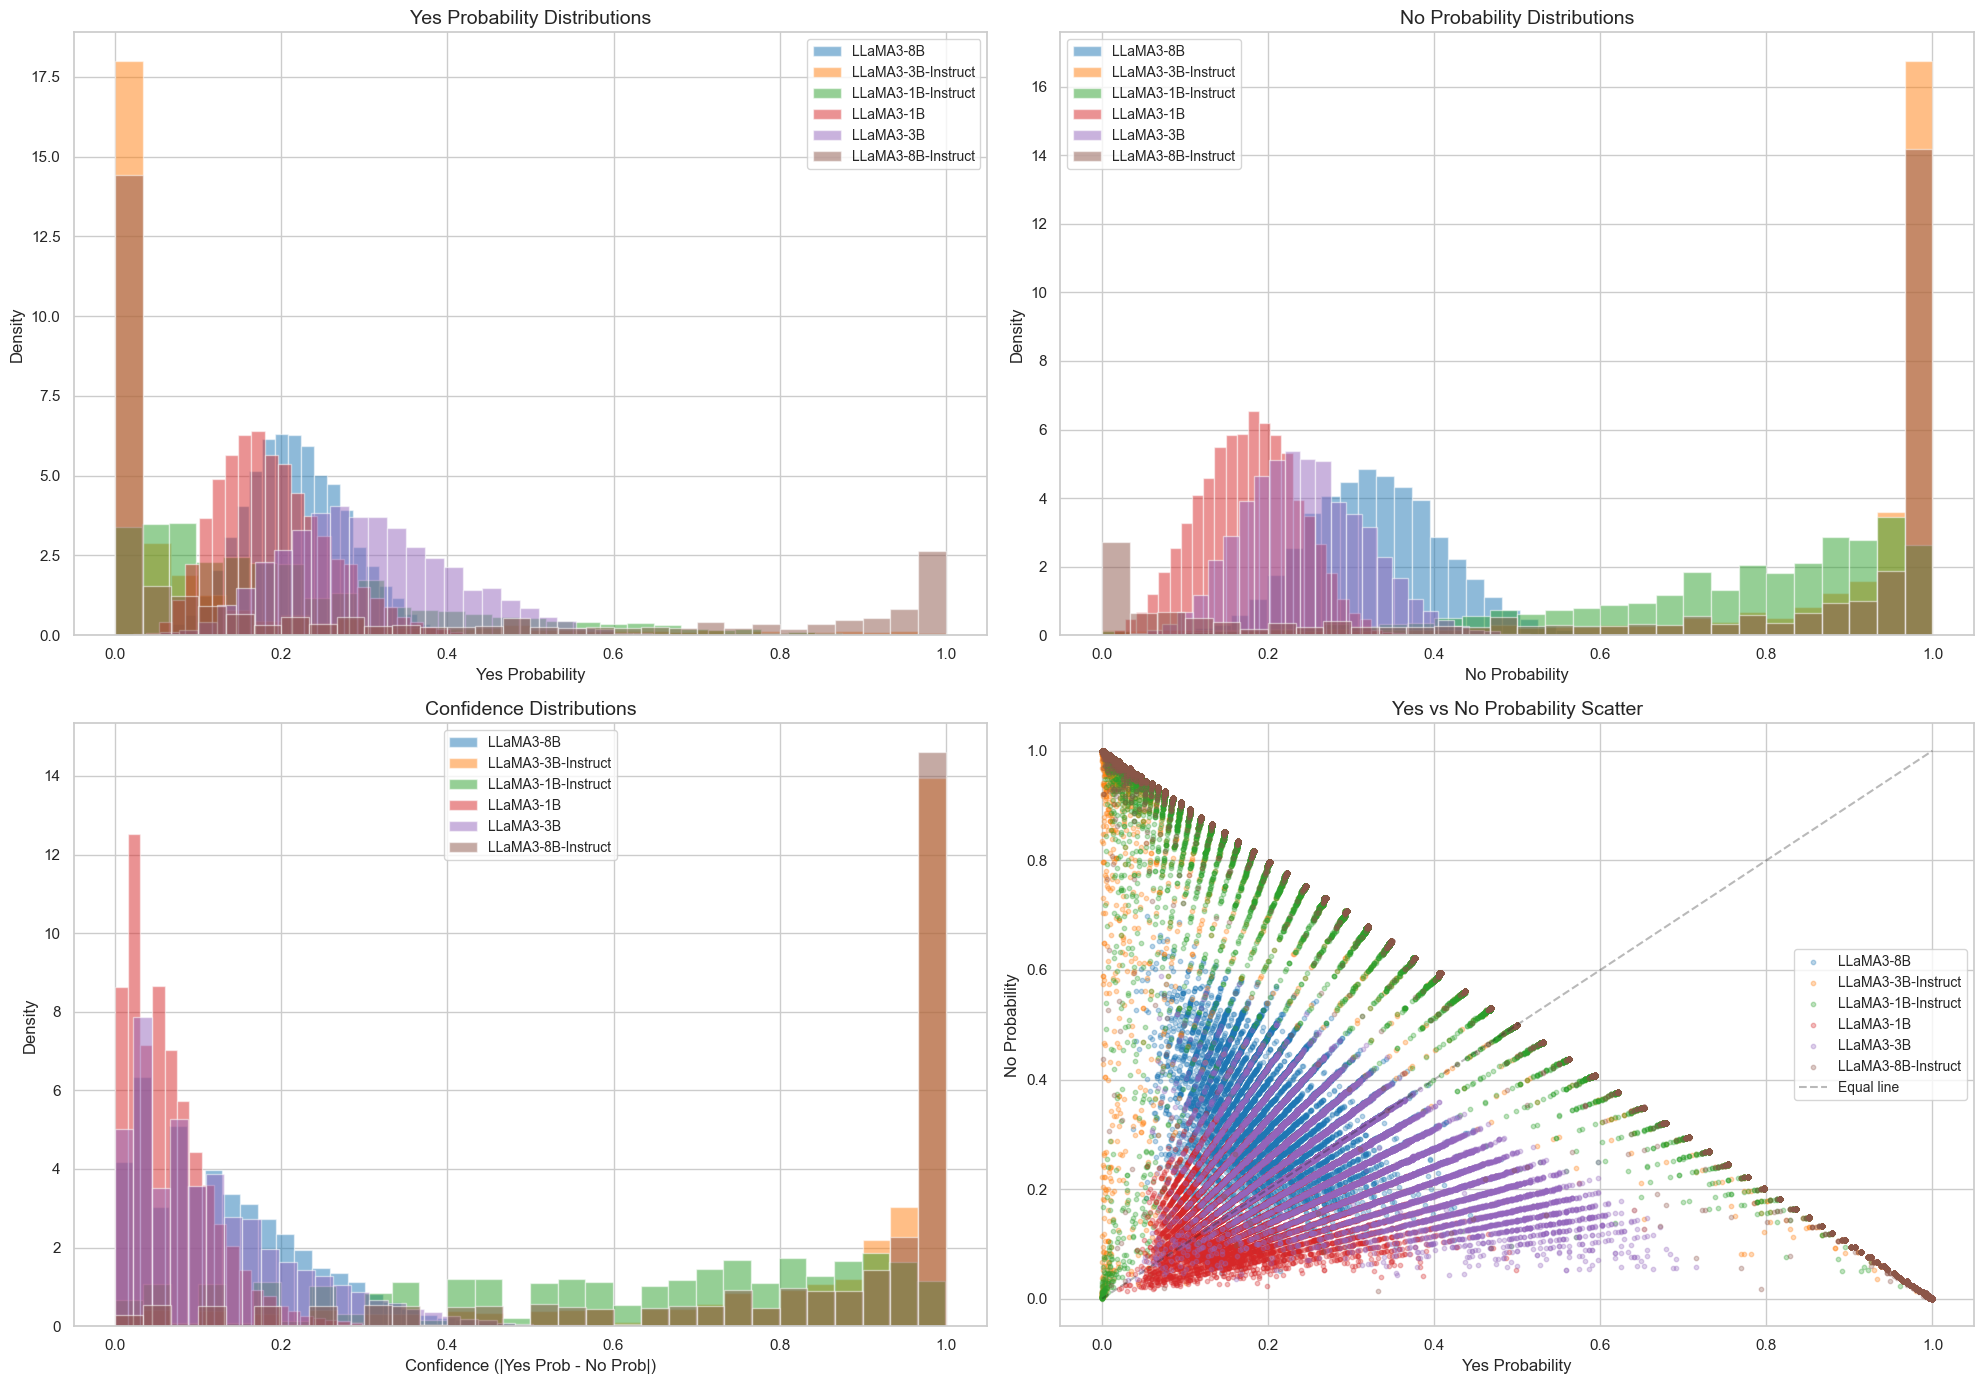


=== PROBABILITY STATISTICS COMPARISON ===


,avg_yes_prob,std_yes_prob,avg_no_prob,std_no_prob,avg_confidence,std_confidence
model,,,,,,
LLaMA3-8B,0.2195,0.0627,0.3298,0.0827,0.1308,0.0970
LLaMA3-3B-Instruct,0.1013,0.1886,0.8807,0.2112,0.8344,0.2491
LLaMA3-1B-Instruct,0.2169,0.1873,0.7545,0.2065,0.5943,0.2816
LLaMA3-1B,0.1905,0.0667,0.1770,0.0599,0.0645,0.0526
LLaMA3-3B,0.3073,0.1027,0.2443,0.0736,0.1207,0.1017
LLaMA3-8B-Instruct,0.2695,0.3620,0.7276,0.3630,0.8131,0.2706


In [18]:
if len(model_data) > 1:
    import matplotlib.cm as cm

    fig, axes = plt.subplots(2, 2, figsize=(20, 14))

    # Generate short names and color palette
    model_short_names = {k: model_label_map.get(k, k) for k in model_data.keys()}
    color_palette = plt.get_cmap('tab10')
    model_colors = {short_name: color_palette(i) for i, short_name in enumerate(model_short_names.values())}

    # 1. Yes probability distributions
    for model_name, df in model_data.items():
        short = model_short_names[model_name]
        color = model_colors[short]
        axes[0, 0].hist(df['yes_probability'], bins=30, alpha=0.5, label=short, color=color, density=True)
    axes[0, 0].set_title('Yes Probability Distributions', fontsize=14)
    axes[0, 0].set_xlabel('Yes Probability')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend(fontsize=10)

    # 2. No probability distributions
    for model_name, df in model_data.items():
        short = model_short_names[model_name]
        color = model_colors[short]
        axes[0, 1].hist(df['no_probability'], bins=30, alpha=0.5, label=short, color=color, density=True)
    axes[0, 1].set_title('No Probability Distributions', fontsize=14)
    axes[0, 1].set_xlabel('No Probability')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend(fontsize=10)

    # 3. Confidence distributions
    for model_name, df in model_data.items():
        short = model_short_names[model_name]
        color = model_colors[short]
        axes[1, 0].hist(df['confidence'], bins=30, alpha=0.5, label=short, color=color, density=True)
    axes[1, 0].set_title('Confidence Distributions', fontsize=14)
    axes[1, 0].set_xlabel('Confidence (|Yes Prob - No Prob|)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend(fontsize=10)

    # 4. Yes vs No probability scatter
    for model_name, df in model_data.items():
        short = model_short_names[model_name]
        color = model_colors[short]
        axes[1, 1].scatter(df['yes_probability'], df['no_probability'], alpha=0.3, label=short, color=color, s=10)
    axes[1, 1].set_title('Yes vs No Probability Scatter', fontsize=14)
    axes[1, 1].set_xlabel('Yes Probability')
    axes[1, 1].set_ylabel('No Probability')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Equal line')
    axes[1, 1].legend(fontsize=10)

    plt.tight_layout()
    plt.show()

    # --- STATISTICAL SUMMARY ---
    print("\n=== PROBABILITY STATISTICS COMPARISON ===")
    prob_stats = []
    for model_name, df in model_data.items():
        short = model_short_names[model_name]
        stats = {
            'model': short,
            'avg_yes_prob': df['yes_probability'].mean(),
            'std_yes_prob': df['yes_probability'].std(),
            'avg_no_prob': df['no_probability'].mean(),
            'std_no_prob': df['no_probability'].std(),
            'avg_confidence': df['confidence'].mean(),
            'std_confidence': df['confidence'].std()
        }
        prob_stats.append(stats)

    prob_stats_df = pd.DataFrame(prob_stats).set_index('model')
    display(prob_stats_df.round(4))

else:
    print("Need at least 2 models for comparison.")


#### Probability Distribution Analysis Summary

LLaMA3-Instruct models show high-confidence behavior, with confidence scores clustered near 1.0 and large gaps between yes and no probabilities. In contrast, base models (e.g. LLaMA3-1B, 3B, 8B) are generally less confident, with tighter yes/no probabilities and lower average confidence (e.g., 0.06–0.13). The scatter plot confirms this: Instruct models cluster at the plot’s extremes, while base models hover around the diagonal, indicating more uncertainty. This demonstrates that instruction tuning increases decisiveness and polarization of output probabilities.

## Advanced Analysis: Category × Dimension Interactions

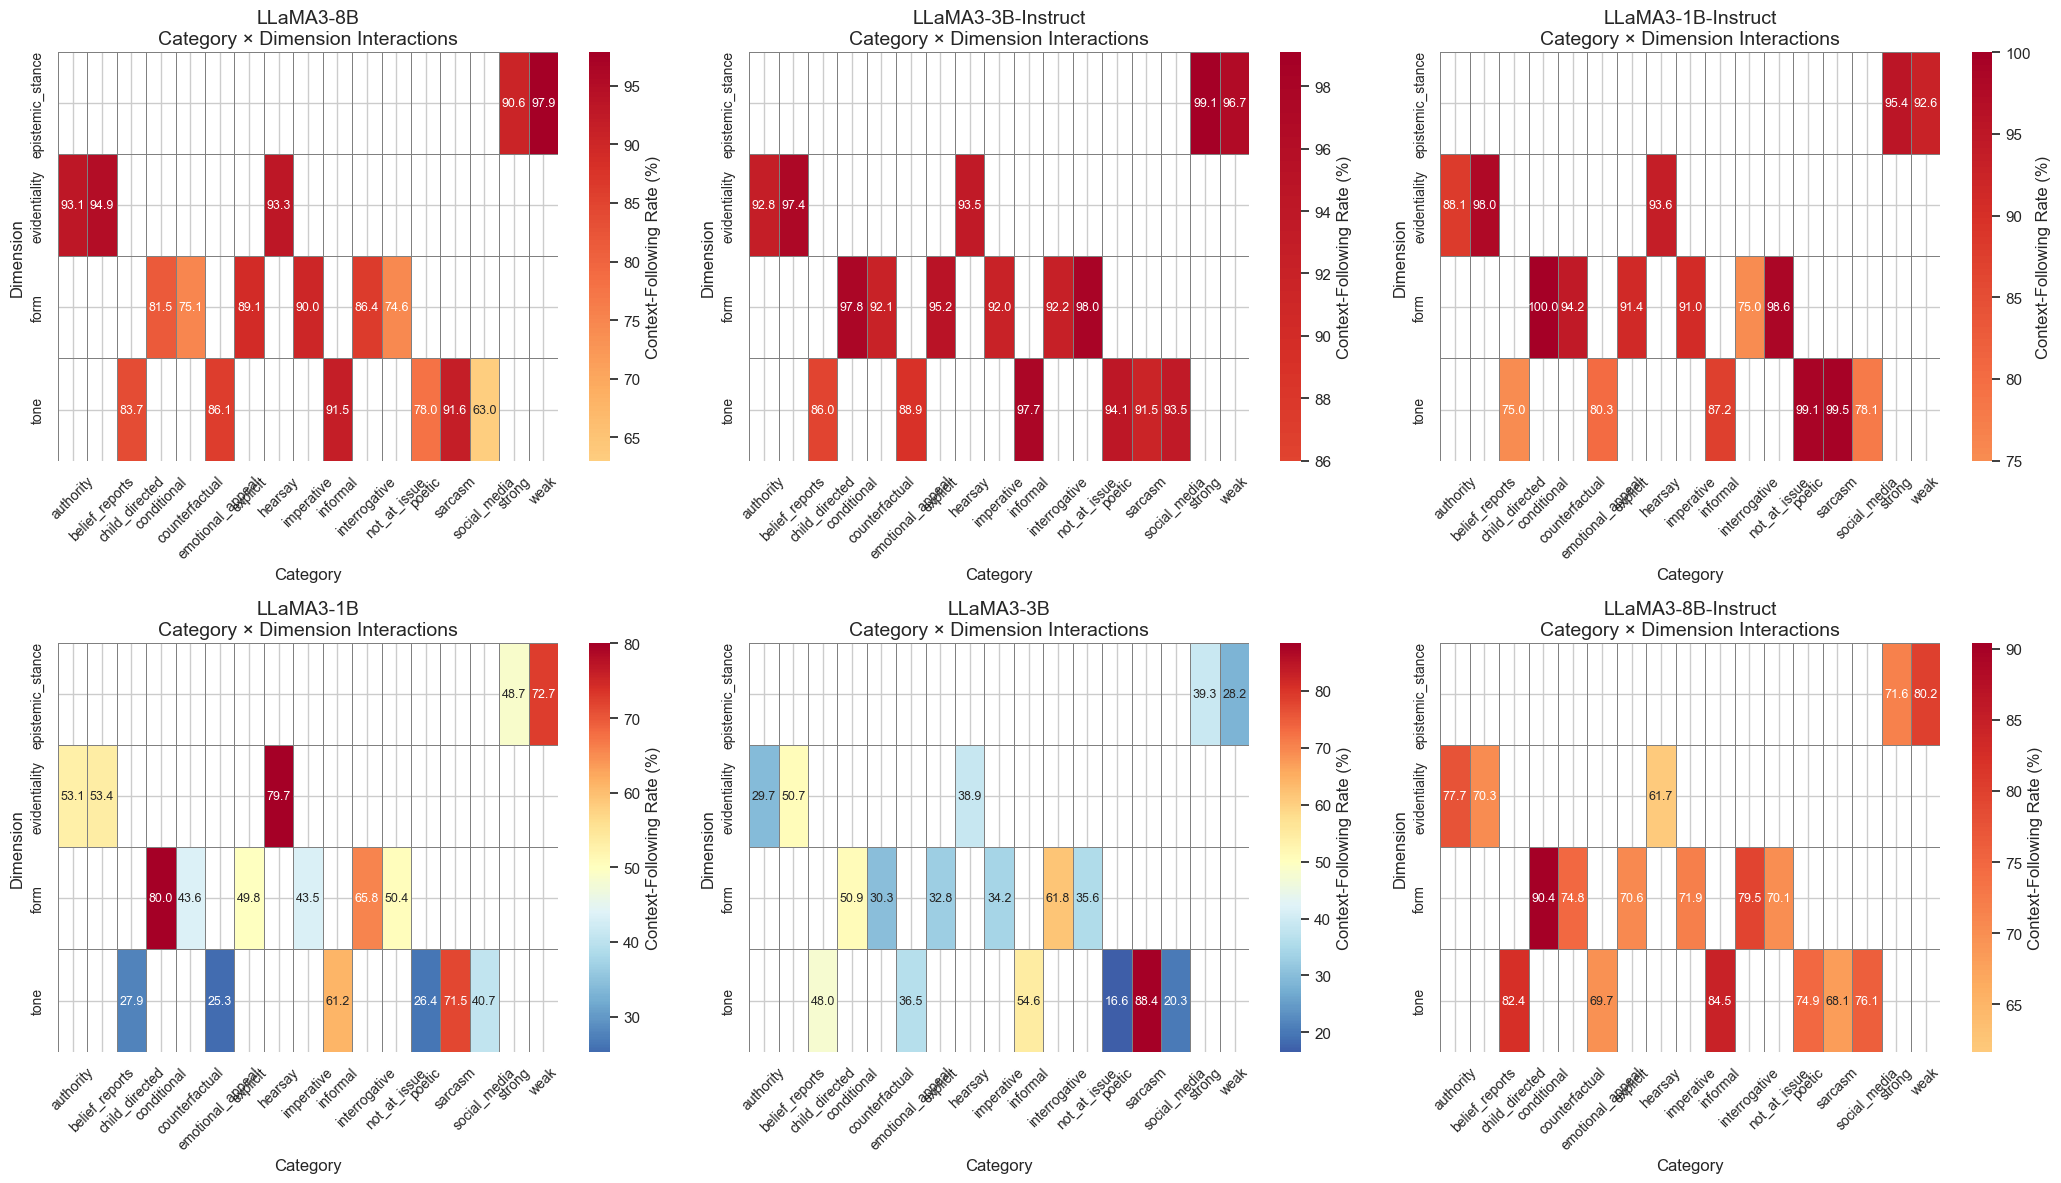


=== CATEGORY × DIMENSION INTERACTION ANALYSIS ===

LLaMA3-8B:


category,authority,belief_reports,child_directed,conditional,counterfactual,emotional_appeal,explicit,hearsay,imperative,informal,interrogative,not_at_issue,poetic,sarcasm,social_media,strong,weak
dimension,,,,,,,,,,,,,,,,,
epistemic_stance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.6,97.9
evidentiality,93.1,94.9,NaN,NaN,NaN,NaN,NaN,93.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
form,NaN,NaN,NaN,81.5,75.1,NaN,89.1,NaN,90.0,NaN,86.4,74.6,NaN,NaN,NaN,NaN,NaN
tone,NaN,NaN,83.7,NaN,NaN,86.1,NaN,NaN,NaN,91.5,NaN,NaN,78.0,91.6,63.0,NaN,NaN



LLaMA3-3B-Instruct:


category,authority,belief_reports,child_directed,conditional,counterfactual,emotional_appeal,explicit,hearsay,imperative,informal,interrogative,not_at_issue,poetic,sarcasm,social_media,strong,weak
dimension,,,,,,,,,,,,,,,,,
epistemic_stance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.1,96.7
evidentiality,92.8,97.4,NaN,NaN,NaN,NaN,NaN,93.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
form,NaN,NaN,NaN,97.8,92.1,NaN,95.2,NaN,92.0,NaN,92.2,98.0,NaN,NaN,NaN,NaN,NaN
tone,NaN,NaN,86.0,NaN,NaN,88.9,NaN,NaN,NaN,97.7,NaN,NaN,94.1,91.5,93.5,NaN,NaN



LLaMA3-1B-Instruct:


category,authority,belief_reports,child_directed,conditional,counterfactual,emotional_appeal,explicit,hearsay,imperative,informal,interrogative,not_at_issue,poetic,sarcasm,social_media,strong,weak
dimension,,,,,,,,,,,,,,,,,
epistemic_stance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.4,92.6
evidentiality,88.1,98.0,NaN,NaN,NaN,NaN,NaN,93.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
form,NaN,NaN,NaN,100.0,94.2,NaN,91.4,NaN,91.0,NaN,75.0,98.6,NaN,NaN,NaN,NaN,NaN
tone,NaN,NaN,75.0,NaN,NaN,80.3,NaN,NaN,NaN,87.2,NaN,NaN,99.1,99.5,78.1,NaN,NaN



LLaMA3-1B:


category,authority,belief_reports,child_directed,conditional,counterfactual,emotional_appeal,explicit,hearsay,imperative,informal,interrogative,not_at_issue,poetic,sarcasm,social_media,strong,weak
dimension,,,,,,,,,,,,,,,,,
epistemic_stance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.7,72.7
evidentiality,53.1,53.4,NaN,NaN,NaN,NaN,NaN,79.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
form,NaN,NaN,NaN,80.0,43.6,NaN,49.8,NaN,43.5,NaN,65.8,50.4,NaN,NaN,NaN,NaN,NaN
tone,NaN,NaN,27.9,NaN,NaN,25.3,NaN,NaN,NaN,61.2,NaN,NaN,26.4,71.5,40.7,NaN,NaN



LLaMA3-3B:


category,authority,belief_reports,child_directed,conditional,counterfactual,emotional_appeal,explicit,hearsay,imperative,informal,interrogative,not_at_issue,poetic,sarcasm,social_media,strong,weak
dimension,,,,,,,,,,,,,,,,,
epistemic_stance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.3,28.2
evidentiality,29.7,50.7,NaN,NaN,NaN,NaN,NaN,38.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
form,NaN,NaN,NaN,50.9,30.3,NaN,32.8,NaN,34.2,NaN,61.8,35.6,NaN,NaN,NaN,NaN,NaN
tone,NaN,NaN,48.0,NaN,NaN,36.5,NaN,NaN,NaN,54.6,NaN,NaN,16.6,88.4,20.3,NaN,NaN



LLaMA3-8B-Instruct:


category,authority,belief_reports,child_directed,conditional,counterfactual,emotional_appeal,explicit,hearsay,imperative,informal,interrogative,not_at_issue,poetic,sarcasm,social_media,strong,weak
dimension,,,,,,,,,,,,,,,,,
epistemic_stance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.6,80.2
evidentiality,77.7,70.3,NaN,NaN,NaN,NaN,NaN,61.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
form,NaN,NaN,NaN,90.4,74.8,NaN,70.6,NaN,71.9,NaN,79.5,70.1,NaN,NaN,NaN,NaN,NaN
tone,NaN,NaN,82.4,NaN,NaN,69.7,NaN,NaN,NaN,84.5,NaN,NaN,74.9,68.1,76.1,NaN,NaN


In [19]:
import math

if len(model_data) > 1:
    # --- Step 1: Compute context-following rate per category × dimension per model ---
    category_dimension_analysis = []

    for model_name, df in model_data.items():
        for category in df['category'].dropna().unique():
            for dimension in df['dimension'].dropna().unique():
                subset = df[(df['category'] == category) & (df['dimension'] == dimension)]

                if not subset.empty:
                    mem = len(subset[subset['classification'] == 'memory'])
                    ctx = len(subset[subset['classification'] == 'context'])
                    total = mem + ctx

                    rate = (ctx / total * 100) if total > 0 else np.nan

                    category_dimension_analysis.append({
                        'model': model_name,
                        'category': category,
                        'dimension': dimension,
                        'context_rate': rate,
                        'total_examples': len(subset),
                        'clear_examples': total
                    })

    cat_dim_df = pd.DataFrame(category_dimension_analysis)

    # --- Step 2: Plot heatmaps per model ---
    if not cat_dim_df.empty:
        cat_dim_df['model_short'] = cat_dim_df['model'].map(model_label_map).fillna(cat_dim_df['model'])
        models = cat_dim_df['model_short'].unique()
        n_models = len(models)

        n_cols = min(n_models, 3)
        n_rows = math.ceil(n_models / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 6 * n_rows), squeeze=False)

        for idx, model_short in enumerate(models):
            row, col = divmod(idx, n_cols)
            ax = axes[row][col]
            model_data_sub = cat_dim_df[cat_dim_df['model_short'] == model_short]
            pivot = model_data_sub.pivot_table(
                values='context_rate',
                index='dimension',
                columns='category',
                aggfunc='mean'
            )

            sns.heatmap(
                pivot,
                annot=True,
                fmt='.1f',
                cmap='RdYlBu_r',
                center=50,
                ax=ax,
                cbar_kws={'label': 'Context-Following Rate (%)'},
                linewidths=0.4,
                linecolor='gray',
                annot_kws={'size': 9}
            )

            ax.set_title(f"{model_short}\nCategory × Dimension Interactions", fontsize=14)
            ax.set_xlabel("Category", fontsize=12)
            ax.set_ylabel("Dimension", fontsize=12)
            ax.tick_params(axis='x', rotation=45, labelsize=10)
            ax.tick_params(axis='y', labelsize=10)

        # Hide unused subplots if any
        for i in range(idx + 1, n_rows * n_cols):
            r, c = divmod(i, n_cols)
            fig.delaxes(axes[r][c])

        plt.tight_layout()
        plt.show()

        # --- Step 3: Print tables ---
        print("\n=== CATEGORY × DIMENSION INTERACTION ANALYSIS ===")
        for model_short in models:
            model_data_sub = cat_dim_df[cat_dim_df['model_short'] == model_short]
            pivot = model_data_sub.pivot_table(
                values='context_rate',
                index='dimension',
                columns='category',
                aggfunc='mean'
            )
            print(f"\n{model_short}:")
            display(pivot.round(1))
    else:
        print("No category-dimension interaction data found.")
else:
    print("Need at least 2 models for comparison.")

CATEGORY × DIMENSION INTERACTION ANALYSIS — Summary

This plot shows how well each model follows context across combinations of assertion categories (e.g., explicit, interrogative) and dimensions (e.g., form, tone, epistemic stance, evidentiality).

Observations:
- Instruction-tuned models (e.g., LLaMA3-3B-Instruct, LLaMA3-8B-Instruct) perform consistently well, with context-following rates often above 90% across all category × dimension pairs.
- Base models (especially LLaMA3-1B and LLaMA3-3B) show reduced and highly variable performance, particularly on the tone and epistemic stance dimensions.
- Some hard combinations emerge across models — notably:
- poetic × tone and social_media × tone often have very low context-following scores in base models (sometimes <30%).
- Form and explicit assertions tend to yield higher scores across most models and dimensions.
- Instruction tuning appears to improve generalization across both category and dimension space, suggesting stronger pragmatic grounding and flexibility.

This interaction view highlights nuanced differences in model behavior that are not visible when analyzing category or dimension in isolation.


## Model Ranking and Summary

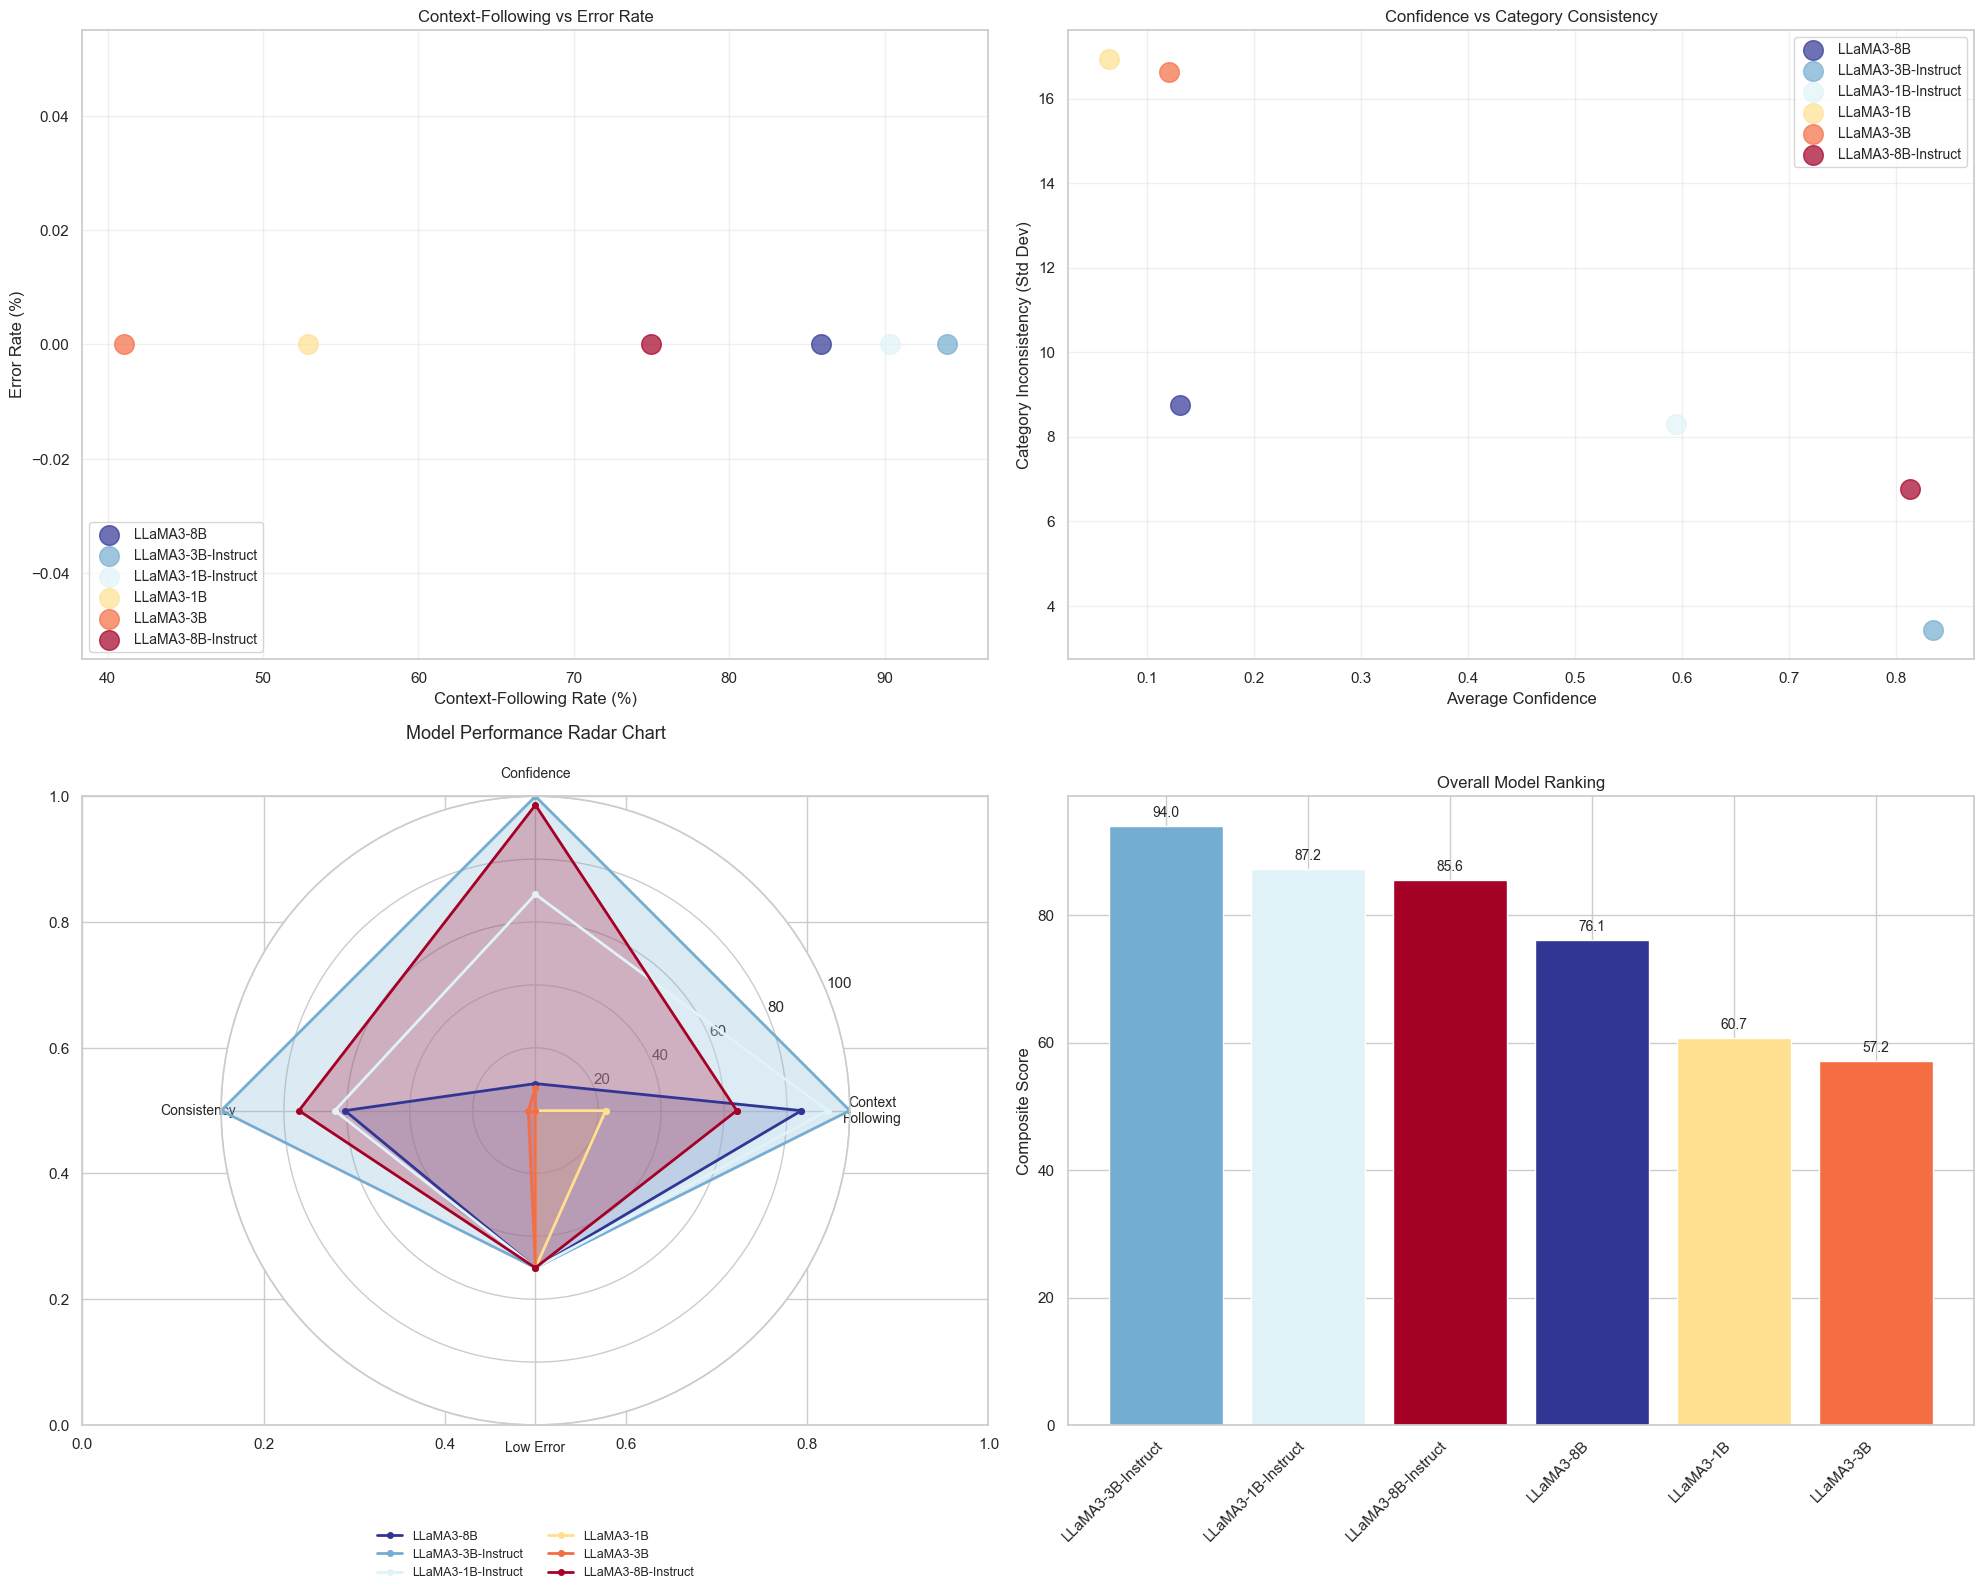


=== COMPREHENSIVE MODEL RANKING ===


,context_following_rate,error_rate,avg_confidence,category_consistency,total_examples,memory_pct,context_pct,other_pct,composite_score
model,,,,,,,,,
LLaMA3-8B,85.88,0.0,0.13,8.75,17000,13.87,84.39,1.74,76.09
LLaMA3-3B-Instruct,94.03,0.0,0.83,3.42,17000,5.89,92.72,1.39,93.96
LLaMA3-1B-Instruct,90.34,0.0,0.59,8.31,17000,9.51,88.96,1.53,87.19
LLaMA3-1B,52.87,0.0,0.06,16.94,17000,41.28,46.31,12.42,60.74
LLaMA3-3B,41.03,0.0,0.12,16.63,17000,57.91,40.29,1.81,57.16
LLaMA3-8B-Instruct,74.97,0.0,0.81,6.77,17000,24.98,74.84,0.18,85.57



=== FINAL RANKING (by composite score) ===

1. LLaMA3-3B-Instruct (Score: 94.0)
   - Context-following rate: 94.0%
   - Error rate: 0.0%
   - Average confidence: 0.834
   - Category consistency: 3.4
   - Total examples: 17000.0

2. LLaMA3-1B-Instruct (Score: 87.2)
   - Context-following rate: 90.3%
   - Error rate: 0.0%
   - Average confidence: 0.594
   - Category consistency: 8.3
   - Total examples: 17000.0

3. LLaMA3-8B-Instruct (Score: 85.6)
   - Context-following rate: 75.0%
   - Error rate: 0.0%
   - Average confidence: 0.813
   - Category consistency: 6.8
   - Total examples: 17000.0

4. LLaMA3-8B (Score: 76.1)
   - Context-following rate: 85.9%
   - Error rate: 0.0%
   - Average confidence: 0.131
   - Category consistency: 8.7
   - Total examples: 17000.0

5. LLaMA3-1B (Score: 60.7)
   - Context-following rate: 52.9%
   - Error rate: 0.0%
   - Average confidence: 0.065
   - Category consistency: 16.9
   - Total examples: 17000.0

6. LLaMA3-3B (Score: 57.2)
   - Context-followi

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

if len(model_data) > 1:
    # Step 1: Calculate model metrics
    model_rankings = []

    for model_name, df in model_data.items():
        memory_count = len(df[df['classification'] == 'memory'])
        context_count = len(df[df['classification'] == 'context'])
        error_count = len(df[df['classification'] == 'error'])
        other_count = len(df[df['classification'] == 'other'])
        total = len(df)

        total_clear = memory_count + context_count
        context_rate = (context_count / total_clear * 100) if total_clear > 0 else 0
        error_rate = error_count / total * 100
        avg_confidence = df['confidence'].mean()

        category_rates = []
        for category in df['category'].dropna().unique():
            cat_df = df[df['category'] == category]
            cat_clear = len(cat_df[cat_df['classification'].isin(['memory', 'context'])])
            cat_context = len(cat_df[cat_df['classification'] == 'context'])
            if cat_clear > 0:
                category_rates.append((cat_context / cat_clear) * 100)
        consistency = np.std(category_rates) if category_rates else 0

        model_rankings.append({
            'model': model_label_map.get(model_name, model_name),
            'context_following_rate': context_rate,
            'error_rate': error_rate,
            'avg_confidence': avg_confidence,
            'category_consistency': consistency,
            'total_examples': total,
            'memory_pct': memory_count / total * 100,
            'context_pct': context_count / total * 100,
            'other_pct': other_count / total * 100,
        })

    ranking_df = pd.DataFrame(model_rankings).set_index('model')

    # Step 2: Create color map based on model order
    cmap = get_cmap("RdYlBu_r")
    norm = Normalize(vmin=0, vmax=len(ranking_df) - 1)
    model_colors = {model: cmap(norm(i)) for i, model in enumerate(ranking_df.index)}

    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # 1. Context-following vs Error rate
    for model_name, row in ranking_df.iterrows():
        color = model_colors[model_name]
        axes[0, 0].scatter(row['context_following_rate'], row['error_rate'], 
                           s=200, color=color, alpha=0.7, label=model_name)
    axes[0, 0].set_xlabel('Context-Following Rate (%)')
    axes[0, 0].set_ylabel('Error Rate (%)')
    axes[0, 0].set_title('Context-Following vs Error Rate')
    axes[0, 0].legend(loc='lower left', fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Confidence vs Consistency
    for model_name, row in ranking_df.iterrows():
        color = model_colors[model_name]
        axes[0, 1].scatter(row['avg_confidence'], row['category_consistency'], 
                           s=200, color=color, alpha=0.7, label=model_name)
    axes[0, 1].set_xlabel('Average Confidence')
    axes[0, 1].set_ylabel('Category Inconsistency (Std Dev)')
    axes[0, 1].set_title('Confidence vs Category Consistency')
    axes[0, 1].legend(loc='upper right', fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Radar chart
    # 3. Radar chart
    metrics = ['context_following_rate', 'avg_confidence', 'category_consistency', 'error_rate']
    normalized_df = ranking_df[metrics].copy()
    for metric in metrics:
        if metric in ['error_rate', 'category_consistency']:
            normalized_df[metric] = 100 - ((normalized_df[metric] - normalized_df[metric].min()) /
                                        (normalized_df[metric].max() - normalized_df[metric].min()) * 100)
        else:
            normalized_df[metric] = ((normalized_df[metric] - normalized_df[metric].min()) /
                                    (normalized_df[metric].max() - normalized_df[metric].min()) * 100)
    normalized_df = normalized_df.fillna(50)

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    ax3 = plt.subplot(2, 2, 3, projection='polar')
    for model_name in normalized_df.index:
        values = normalized_df.loc[model_name].tolist() + [normalized_df.loc[model_name].tolist()[0]]
        color = model_colors[model_name]
        ax3.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color, markersize=4)
        ax3.fill(angles, values, alpha=0.25, color=color)

    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(['Context\nFollowing', 'Confidence', 'Consistency', 'Low Error'], fontsize=10)
    ax3.set_ylim(0, 100)
    ax3.set_title('Model Performance Radar Chart', fontsize=13, pad=20)

    # Move legend below the plot
    ax3.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        fontsize=9,
        frameon=False
    )

    # 4. Overall ranking
    ranking_df['composite_score'] = (
        ranking_df['context_following_rate'] * 0.4 +
        (100 - ranking_df['error_rate']) * 0.3 +
        ranking_df['avg_confidence'] * 100 * 0.2 +
        (100 - ranking_df['category_consistency']) * 0.1
    )

    ranking_sorted = ranking_df.sort_values('composite_score', ascending=False)
    bar_colors = [model_colors[name] for name in ranking_sorted.index]

    bars = axes[1, 1].bar(range(len(ranking_sorted)), ranking_sorted['composite_score'], color=bar_colors)
    axes[1, 1].set_xticks(range(len(ranking_sorted)))
    axes[1, 1].set_xticklabels(ranking_sorted.index, rotation=45, ha='right')
    axes[1, 1].set_ylabel('Composite Score')
    axes[1, 1].set_title('Overall Model Ranking')
    for bar, score in zip(bars, ranking_sorted['composite_score']):
        axes[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
                       f'{score:.1f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Summary print
    print("\n=== COMPREHENSIVE MODEL RANKING ===")
    display(ranking_df.round(2))
    print("\n=== FINAL RANKING (by composite score) ===")
    for i, (model_name, row) in enumerate(ranking_sorted.iterrows(), 1):
        print(f"\n{i}. {model_name} (Score: {row['composite_score']:.1f})")
        print(f"   - Context-following rate: {row['context_following_rate']:.1f}%")
        print(f"   - Error rate: {row['error_rate']:.1f}%")
        print(f"   - Average confidence: {row['avg_confidence']:.3f}")
        print(f"   - Category consistency: {row['category_consistency']:.1f}")
        print(f"   - Total examples: {row['total_examples']}")
else:
    print("Need at least 2 models for ranking.")

## Key Insights and Recommendations

In [21]:
if len(model_data) > 1:
    print("=== KEY INSIGHTS AND RECOMMENDATIONS ===")
    
    # Best and worst performers
    best_context_follower = ranking_df['context_following_rate'].idxmax()
    worst_context_follower = ranking_df['context_following_rate'].idxmin()
    lowest_error = ranking_df['error_rate'].idxmin()
    highest_confidence = ranking_df['avg_confidence'].idxmax()
    most_consistent = ranking_df['category_consistency'].idxmin()
    
    print(f"\n1. CONTEXT SUSCEPTIBILITY:")
    print(f"   - Most susceptible to context: {best_context_follower} ({ranking_df.loc[best_context_follower, 'context_following_rate']:.1f}%)")
    print(f"   - Most resistant to context: {worst_context_follower} ({ranking_df.loc[worst_context_follower, 'context_following_rate']:.1f}%)")
    
    print(f"\n2. RELIABILITY:")
    print(f"   - Lowest error rate: {lowest_error} ({ranking_df.loc[lowest_error, 'error_rate']:.1f}%)")
    print(f"   - Highest confidence: {highest_confidence} ({ranking_df.loc[highest_confidence, 'avg_confidence']:.3f})")
    print(f"   - Most consistent across categories: {most_consistent} (std dev: {ranking_df.loc[most_consistent, 'category_consistency']:.1f})")
    
    print(f"\n3. CATEGORY INSIGHTS:")
    if 'effectiveness_df' in locals():
        # Find most and least effective categories
        category_means = effectiveness_df.mean(axis=1).sort_values(ascending=False)
        most_effective_cat = category_means.index[0] if len(category_means) > 0 else "N/A"
        least_effective_cat = category_means.index[-1] if len(category_means) > 0 else "N/A"
        
        print(f"   - Most effective category (highest context-following): {most_effective_cat}")
        print(f"   - Least effective category (lowest context-following): {least_effective_cat}")
    
    print(f"\n4. RECOMMENDATIONS:")
    print(f"   - For testing context susceptibility: Use {best_context_follower}")
    print(f"   - For robust performance: Use {lowest_error}")
    print(f"   - For consistent behavior: Use {most_consistent}")
    
    # Model-specific insights
    print(f"\n5. MODEL-SPECIFIC INSIGHTS:")
    for model_name, row in ranking_df.iterrows():
        print(f"\n   {model_name}:")
        
        # Context sensitivity
        if row['context_following_rate'] > 60:
            print(f"     + Highly susceptible to contextual assertions")
        elif row['context_following_rate'] < 40:
            print(f"     + Resistant to contextual manipulation")
        else:
            print(f"     + Moderate context sensitivity")
        
        # Reliability
        if row['error_rate'] < 5:
            print(f"     + Very reliable (low error rate)")
        elif row['error_rate'] > 15:
            print(f"     - High error rate, may need improvement")
        
        # Confidence
        if row['avg_confidence'] > 0.5:
            print(f"     + High confidence in responses")
        elif row['avg_confidence'] < 0.1:
            print(f"     - Low confidence, uncertain responses")
        
        # Consistency
        if row['category_consistency'] < 10:
            print(f"     + Consistent across different categories")
        elif row['category_consistency'] > 25:
            print(f"     - Inconsistent behavior across categories")
else:
    print("Need multiple models for comprehensive insights.")

=== KEY INSIGHTS AND RECOMMENDATIONS ===

1. CONTEXT SUSCEPTIBILITY:
   - Most susceptible to context: LLaMA3-3B-Instruct (94.0%)
   - Most resistant to context: LLaMA3-3B (41.0%)

2. RELIABILITY:
   - Lowest error rate: LLaMA3-8B (0.0%)
   - Highest confidence: LLaMA3-3B-Instruct (0.834)
   - Most consistent across categories: LLaMA3-3B-Instruct (std dev: 3.4)

3. CATEGORY INSIGHTS:

4. RECOMMENDATIONS:
   - For testing context susceptibility: Use LLaMA3-3B-Instruct
   - For robust performance: Use LLaMA3-8B
   - For consistent behavior: Use LLaMA3-3B-Instruct

5. MODEL-SPECIFIC INSIGHTS:

   LLaMA3-8B:
     + Highly susceptible to contextual assertions
     + Very reliable (low error rate)
     + Consistent across different categories

   LLaMA3-3B-Instruct:
     + Highly susceptible to contextual assertions
     + Very reliable (low error rate)
     + High confidence in responses
     + Consistent across different categories

   LLaMA3-1B-Instruct:
     + Highly susceptible to conte

## Export Results

In [22]:
# Save comparison results
if len(model_data) > 1:
    output_dir = Path('comparison_results')
    output_dir.mkdir(exist_ok=True)
    
    # Save detailed comparison data
    comparison_data = {
        'model_rankings': ranking_df.to_dict('index'),
        'category_effectiveness': effectiveness_df.to_dict('index') if 'effectiveness_df' in locals() else {},
        'dimension_effectiveness': dimension_df.to_dict('index') if 'dimension_df' in locals() else {},
        'fact_consistency': fact_df.to_dict('index') if 'fact_df' in locals() else {},
        'probability_statistics': prob_stats_df.to_dict('index') if 'prob_stats_df' in locals() else {},
        'model_correlations': correlations if 'correlations' in locals() else [],
        'summary': {
            'total_models': len(model_data),
            'best_context_follower': ranking_df['context_following_rate'].idxmax(),
            'most_reliable': ranking_df['error_rate'].idxmin(),
            'most_confident': ranking_df['avg_confidence'].idxmax(),
            'most_consistent': ranking_df['category_consistency'].idxmin()
        }
    }
    
    # Save to JSON
    with open(output_dir / 'model_comparison_results.json', 'w') as f:
        json.dump(comparison_data, f, indent=2, default=str)
    
    # Save CSV files
    ranking_df.to_csv(output_dir / 'model_rankings.csv')
    if 'effectiveness_df' in locals():
        effectiveness_df.to_csv(output_dir / 'category_effectiveness.csv')
    if 'dimension_df' in locals():
        dimension_df.to_csv(output_dir / 'dimension_effectiveness.csv')
    
    print(f"\nComparison results saved to {output_dir}/")
    print(f"Files created:")
    print(f"  - model_comparison_results.json (comprehensive results)")
    print(f"  - model_rankings.csv (model performance metrics)")
    print(f"  - category_effectiveness.csv (category analysis)")
    print(f"  - dimension_effectiveness.csv (dimension analysis)")
else:
    print("Need multiple models to save comparison results.")


Comparison results saved to comparison_results/
Files created:
  - model_comparison_results.json (comprehensive results)
  - model_rankings.csv (model performance metrics)
  - category_effectiveness.csv (category analysis)
  - dimension_effectiveness.csv (dimension analysis)


In [23]:
from pathlib import Path
import json

if len(model_data) > 1:
    output_dir = Path('comparison_results')
    output_dir.mkdir(exist_ok=True)

    # Save detailed comparison data
    comparison_data = {
        'model_rankings': ranking_df.to_dict('index') if 'ranking_df' in locals() else {},
        'category_effectiveness': effectiveness_df.to_dict('index') if 'effectiveness_df' in locals() else {},
        'dimension_effectiveness': dimension_df.to_dict('index') if 'dimension_df' in locals() else {},
        'fact_consistency': fact_df.to_dict('index') if 'fact_df' in locals() else {},
        'probability_statistics': prob_stats_df.to_dict('index') if 'prob_stats_df' in locals() else {},
        'category_dimension_interactions': cat_dim_df.to_dict('records') if 'cat_dim_df' in locals() else [],
        'model_correlations': correlations if 'correlations' in locals() else [],
        'summary': {
            'total_models': len(model_data),
            'best_context_follower': ranking_df['context_following_rate'].idxmax() if 'ranking_df' in locals() else None,
            'most_reliable': ranking_df['error_rate'].idxmin() if 'ranking_df' in locals() else None,
            'most_confident': ranking_df['avg_confidence'].idxmax() if 'ranking_df' in locals() else None,
            'most_consistent': ranking_df['category_consistency'].idxmin() if 'ranking_df' in locals() else None
        }
    }

    # Save to JSON
    with open(output_dir / 'model_comparison_results.json', 'w') as f:
        json.dump(comparison_data, f, indent=2, default=str)

    # Save tabular CSVs
    if 'ranking_df' in locals():
        ranking_df.to_csv(output_dir / 'model_rankings.csv')
    if 'effectiveness_df' in locals():
        effectiveness_df.to_csv(output_dir / 'category_effectiveness.csv')
    if 'dimension_df' in locals():
        dimension_df.to_csv(output_dir / 'dimension_effectiveness.csv')
    if 'fact_df' in locals():
        fact_df.to_csv(output_dir / 'fact_level_consistency.csv')
    if 'prob_stats_df' in locals():
        prob_stats_df.to_csv(output_dir / 'probability_statistics.csv')
    if 'cat_dim_df' in locals():
        cat_dim_df.to_csv(output_dir / 'category_dimension_interactions.csv', index=False)

    print(f"\n✅ Comparison results saved to {output_dir}/")
    print("Files created:")
    print("  - model_comparison_results.json (all results serialized)")
    print("  - model_rankings.csv")
    print("  - category_effectiveness.csv")
    print("  - dimension_effectiveness.csv")
    print("  - fact_level_consistency.csv")
    print("  - probability_statistics.csv")
    print("  - category_dimension_interactions.csv")

else:
    print("Need multiple models to save comparison results.")


✅ Comparison results saved to comparison_results/
Files created:
  - model_comparison_results.json (all results serialized)
  - model_rankings.csv
  - category_effectiveness.csv
  - dimension_effectiveness.csv
  - fact_level_consistency.csv
  - probability_statistics.csv
  - category_dimension_interactions.csv
